In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os
import argparse

In [51]:
def plot_histogram(data, title, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data , fill=True, color='orange', alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xlim(0, max(data) )  # Set x-axis limit with some padding
    plt.axvline(x=np.mean(data), color='b', linestyle='--', label=f'Mean: {np.mean(data):.3f}')
    plt.axvline(x=np.median(data), color='g', linestyle='--', label=f'Median: {np.median(data):.3f}')
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # plt.savefig(f'{title}.png')
    plt.show()

Successfully loaded 96188 data points.

First few rows:
                timestamp beat_type  rr_interval next_beat_type  relative_time
0 1988-10-18 15:02:39.727         N        0.859              N          0.000
1 1988-10-18 15:02:40.586         N        0.828              N          0.859
2 1988-10-18 15:02:41.414         N        0.797              N          1.687
3 1988-10-18 15:02:42.211         N        0.852              N          2.484
4 1988-10-18 15:02:43.063         N        0.703              N          3.336
Beat Type Distribution:
  N: 92820 beats (96.5%)
  V: 1970 beats (2.0%)
  Q: 786 beats (0.8%)
  A: 612 beats (0.6%)

VPC Frequency: 1.38 per minute


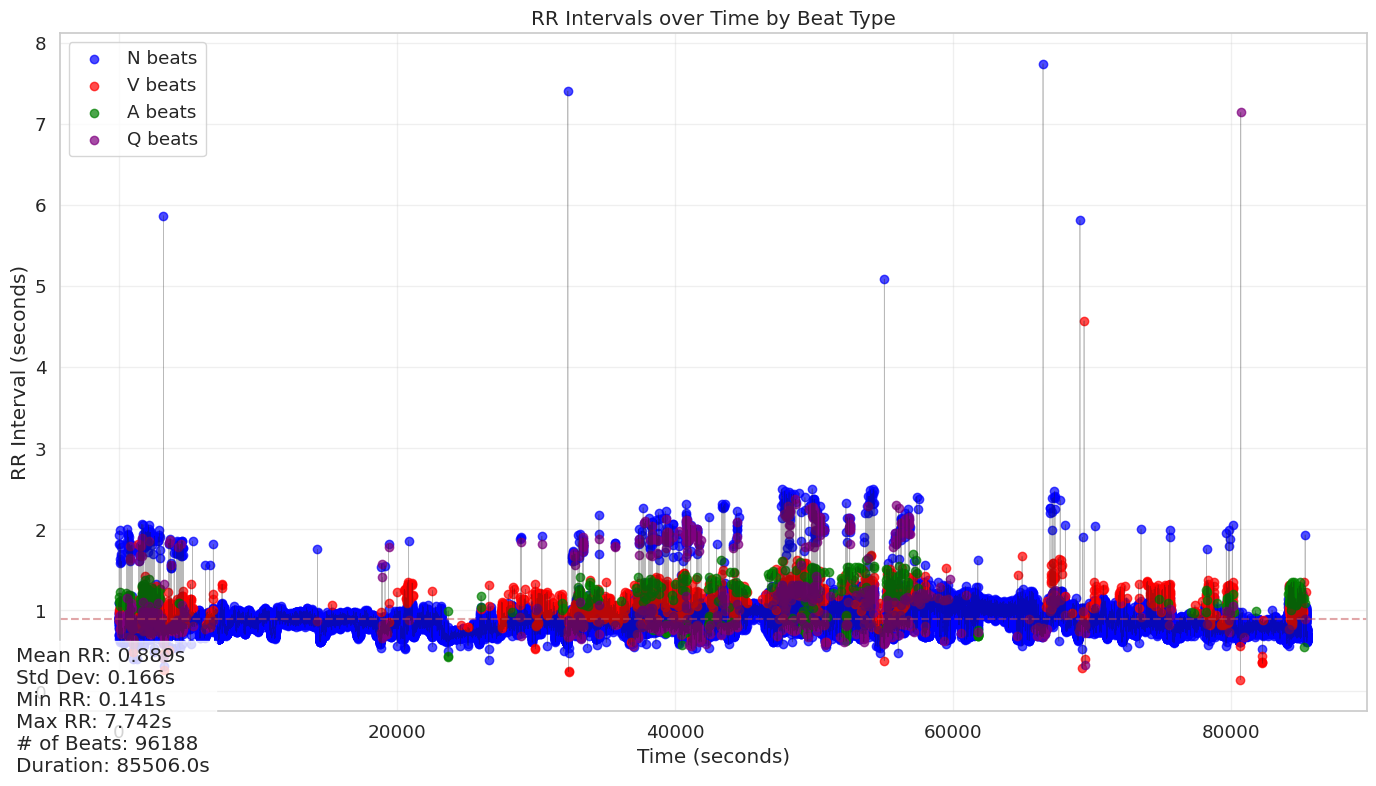

Successfully loaded 87981 data points.

First few rows:
                timestamp beat_type  rr_interval next_beat_type  relative_time
0 1988-11-08 11:28:52.977         N        0.805              N          0.000
1 1988-11-08 11:28:53.781         N        0.805              N          0.804
2 1988-11-08 11:28:54.586         N        0.836              N          1.609
3 1988-11-08 11:28:55.422         N        0.852              N          2.445
4 1988-11-08 11:28:56.273         N        0.836              N          3.296
Beat Type Distribution:
  N: 87640 beats (99.6%)
  Q: 309 beats (0.4%)
  V: 29 beats (0.0%)
  A: 3 beats (0.0%)

VPC Frequency: 0.02 per minute


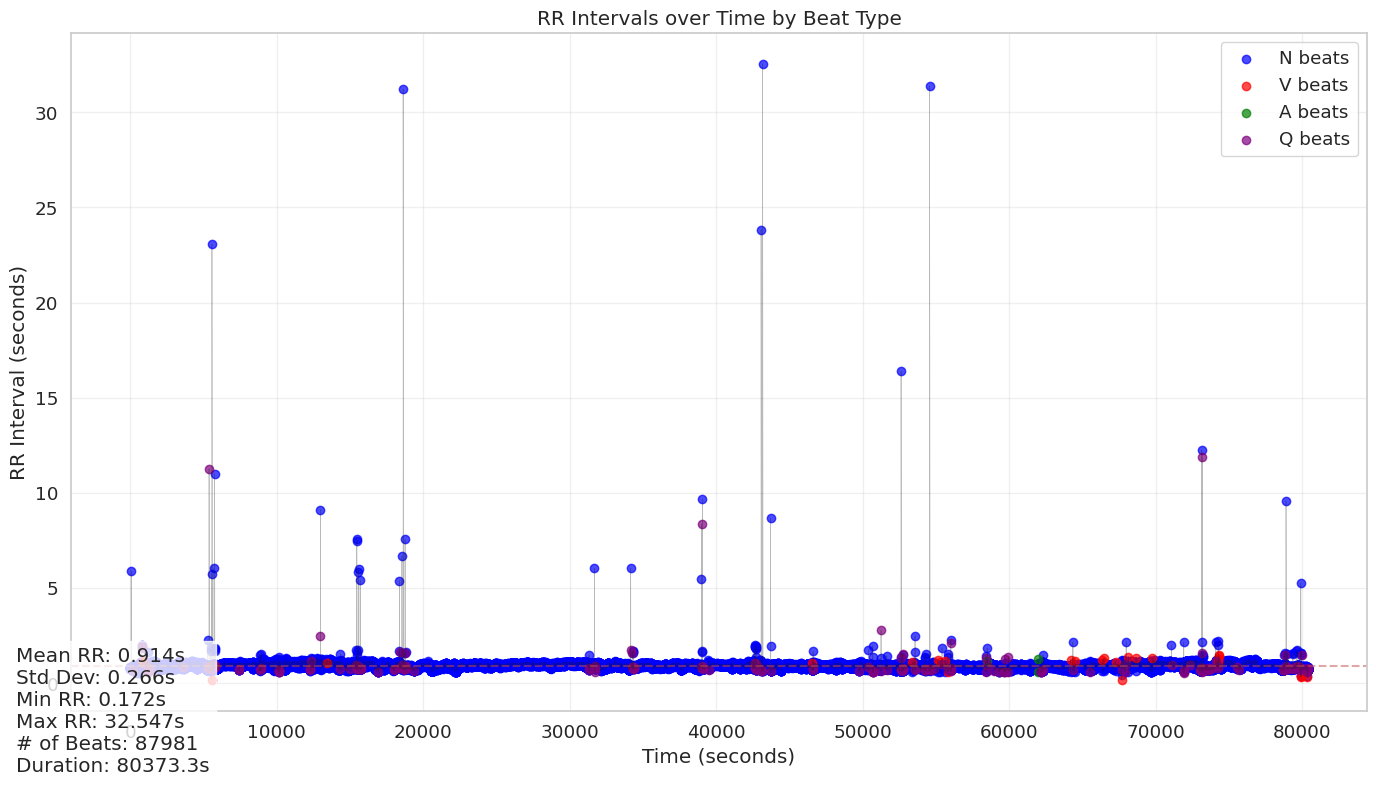

Plotting distribution for N beats (count: 87640)


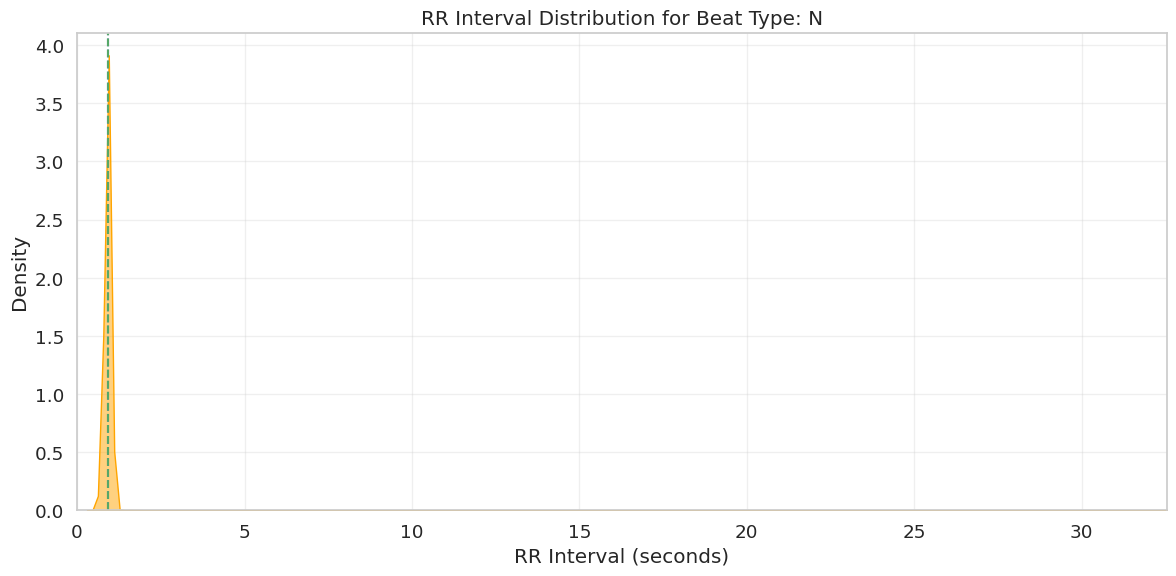

Plotting distribution for Q beats (count: 309)


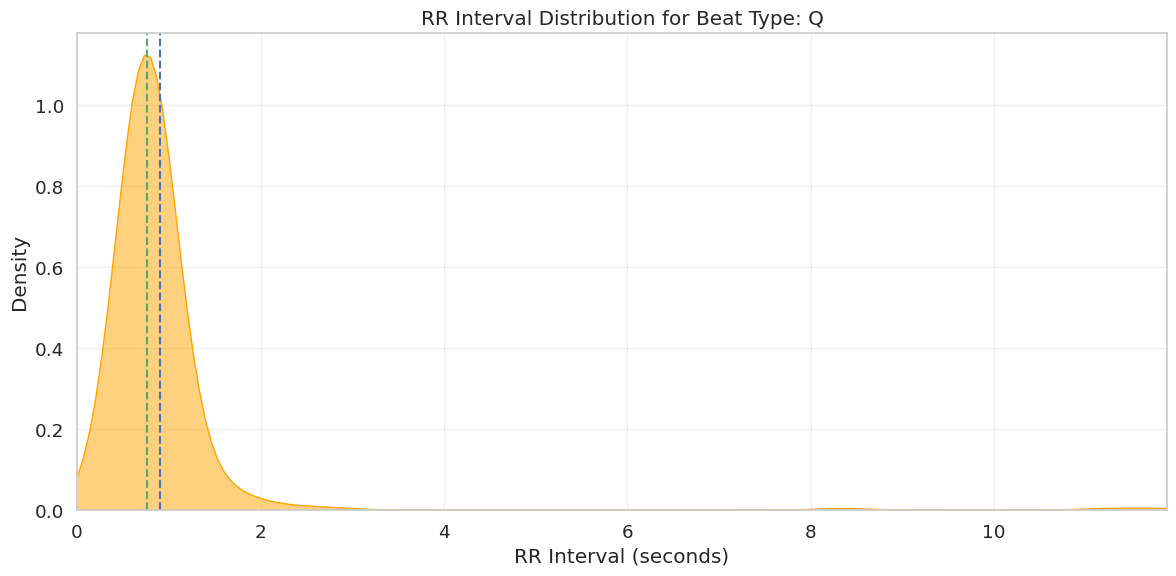

Plotting distribution for V beats (count: 29)


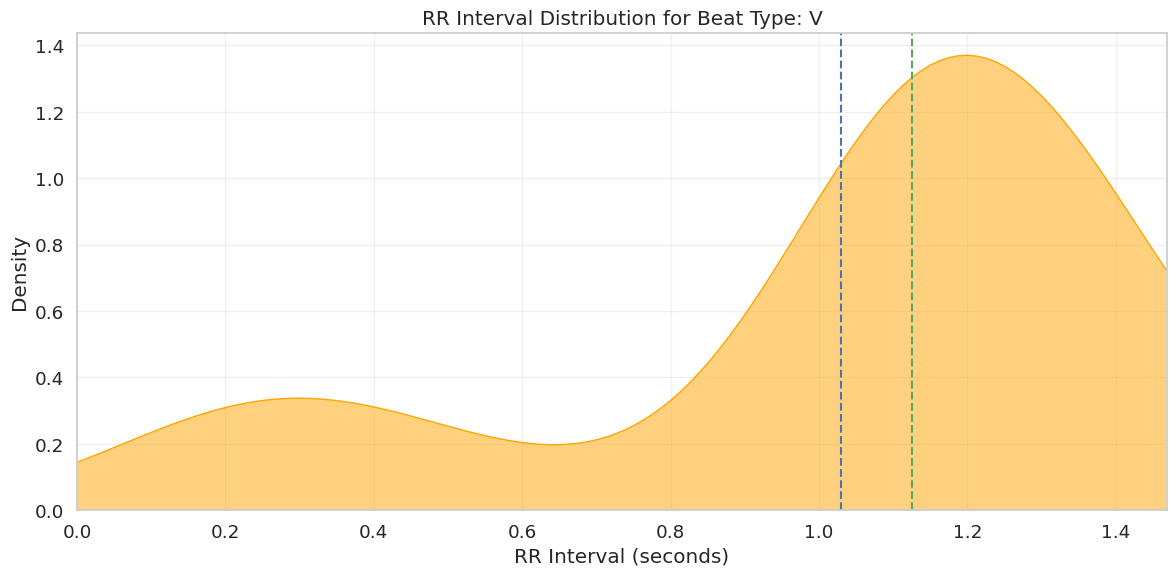

Plotting distribution for A beats (count: 3)


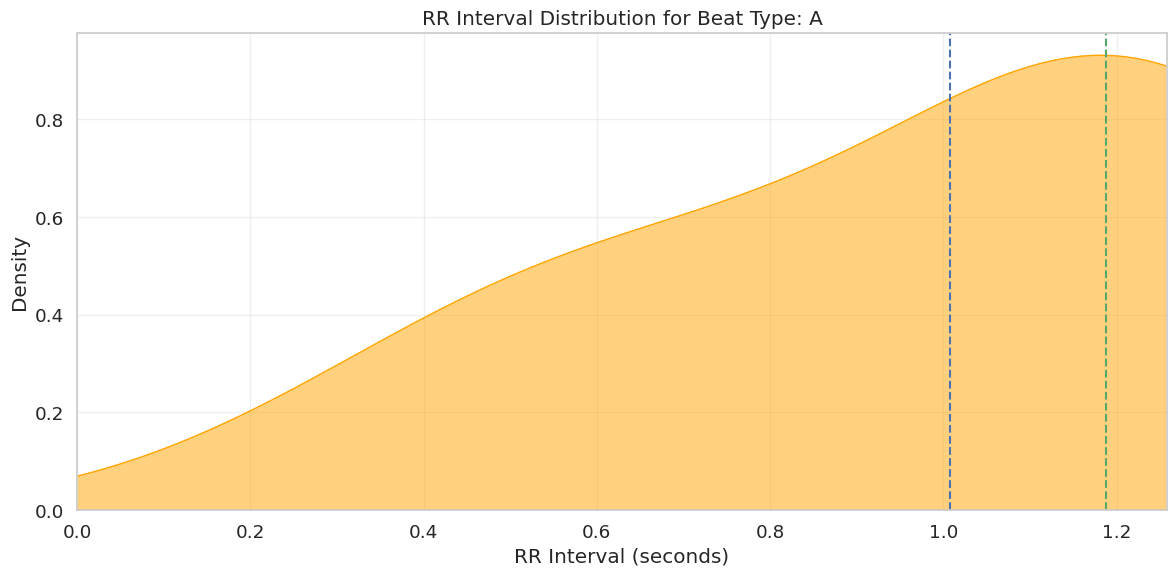

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import datetime

def parse_rr_file(file_path):
    """
    Parse the RR interval file with the specialized format.
    Ignores the first row that contains initialization data.
    
    Format: [timestamp] beat_type interval next_beat_type [next_timestamp]
    """
    # Initialize lists to store data
    timestamps = []
    beat_types = []
    rr_intervals = []
    next_beat_types = []
    relative_times = []  # For plotting relative to first real beat
    
    first_real_timestamp = None
    is_first_line = True
    
    with open(file_path, 'r') as f:
        for line in f:
            # Skip empty lines or lines starting with //
            if not line.strip() or line.strip().startswith('//'):
                continue
                
            # Parse the line using regex
            # Match pattern: [timestamp] beat_type interval next_beat_type [next_timestamp]
            match = re.match(r'\[(.*?)\]\s+(\S+)\s+(\S+)\s+(\S+)\s+\[(.*?)\]', line)
            
            if match:
                start_time_str, beat_type, interval, next_beat_type, _ = match.groups()
                
                # Skip the first line with [0] which is initialization data
                if is_first_line and beat_type == '[0]':
                    is_first_line = False
                    continue
                
                try:
                    # Parse timestamp: HH:MM:SS.SSS DD/MM/YYYY
                    timestamp = datetime.datetime.strptime(start_time_str, '%H:%M:%S.%f %d/%m/%Y')
                    
                    # Track the first real timestamp for relative timing
                    if first_real_timestamp is None:
                        first_real_timestamp = timestamp
                    
                    timestamps.append(timestamp)
                    beat_types.append(beat_type)
                    rr_intervals.append(float(interval))
                    next_beat_types.append(next_beat_type)
                    
                    # Calculate relative time in seconds from first real beat
                    relative_time = (timestamp - first_real_timestamp).total_seconds()
                    relative_times.append(relative_time)
                    
                except ValueError as e:
                    print(f"Error parsing timestamp: {start_time_str}, Error: {e}")
            else:
                print(f"Could not parse line: {line}")
    
    # Create a DataFrame
    df = pd.DataFrame({
        'timestamp': timestamps,
        'beat_type': beat_types,
        'rr_interval': rr_intervals,
        'next_beat_type': next_beat_types,
        'relative_time': relative_times
    })
    
    return df

def plot_rr_intervals(df):
    """Plot RR intervals vs time with beat type coloring."""
    if df.empty:
        print("No data to plot.")
        return
    
    # Set up the plot
    plt.figure(figsize=(14, 8))
    
    # Define colors for different beat types
    beat_colors = {
        'N': 'blue',     # Normal beat
        'V': 'red',      # Ventricular premature beat
        'A': 'green',    # Atrial premature beat
        'Q': 'purple'    # Unclassified beat
    }
    
    # Create scatter plot with points colored by beat type
    for beat_type, color in beat_colors.items():
        mask = df['beat_type'] == beat_type
        if any(mask):
            plt.scatter(df.loc[mask, 'relative_time'], 
                       df.loc[mask, 'rr_interval'], 
                       c=color, 
                       label=f"{beat_type} beats",
                       alpha=0.7)
    
    # Connect points with a line
    plt.plot(df['relative_time'], df['rr_interval'], 'k-', alpha=0.3, linewidth=0.5)
    
    # Add labels and title
    plt.xlabel('Time (seconds)')
    plt.ylabel('RR Interval (seconds)')
    plt.title('RR Intervals over Time by Beat Type')
    
    # Add a legend
    plt.legend()
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Calculate statistics
    mean_rr = df['rr_interval'].mean()
    std_rr = df['rr_interval'].std()
    
    # Add a horizontal line at the mean RR interval
    plt.axhline(y=mean_rr, color='r', linestyle='--', alpha=0.5)
    
    # Add statistics to the plot
    stats_text = (f"Mean RR: {mean_rr:.3f}s\n"
                  f"Std Dev: {std_rr:.3f}s\n"
                  f"Min RR: {df['rr_interval'].min():.3f}s\n"
                  f"Max RR: {df['rr_interval'].max():.3f}s\n"
                  f"# of Beats: {len(df)}\n"
                  f"Duration: {df['relative_time'].max():.1f}s")
    
    plt.figtext(0.02, 0.02, stats_text, bbox=dict(facecolor='white', alpha=0.8))
    
    # Show the plot
    plt.tight_layout()
    plt.show()

def analyze_beat_distribution(df):
    """Analyze and print beat type distribution."""
    if df.empty:
        print("No data to analyze.")
        return
    
    # Count the different beat types
    beat_counts = df['beat_type'].value_counts()
    
    # Print the beat distribution
    print("Beat Type Distribution:")
    for beat_type, count in beat_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {beat_type}: {count} beats ({percentage:.1f}%)")
    
    # Calculate the frequency of VPCs (Ventricular Premature Complexes)
    if 'V' in beat_counts:
        vpc_count = beat_counts['V']
        total_time_seconds = df['relative_time'].max()
        # Calculate VPC per minute
        vpc_per_minute = (vpc_count / total_time_seconds) * 60
        print(f"\nVPC Frequency: {vpc_per_minute:.2f} per minute")

# Main execution
if __name__ == "__main__":
    file_path = "/home/rajea/Workspace/Sem-6/Bayesian Statistics/physionet.org/files/rr_e/e003a.txt"
    
    # Parse the file
    df = parse_rr_file(file_path)
    
    if not df.empty:
        print(f"Successfully loaded {len(df)} data points.")
        
        # Show first few rows
        print("\nFirst few rows:")
        print(df.head())
        
        # Analyze beat distribution
        analyze_beat_distribution(df)
        
        # Create the plot
        plot_rr_intervals(df)
    else:
        print("No data was loaded from the file.")
    file_path = "/home/rajea/Workspace/Sem-6/Bayesian Statistics/physionet.org/files/rr_e/e003b.txt"
    
    # Parse the file
    df = parse_rr_file(file_path)
    
    if not df.empty:
        print(f"Successfully loaded {len(df)} data points.")
        
        # Show first few rows
        print("\nFirst few rows:")
        print(df.head())
        
        # Analyze beat distribution
        analyze_beat_distribution(df)
        
        # Create the plot
        plot_rr_intervals(df)
    else:
        print("No data was loaded from the file.")
        # Plot PDF for each beat type
    beat_types = df['beat_type'].unique()
    for beat_type in beat_types:
            beat_data = df[df['beat_type'] == beat_type]['rr_interval']
            if len(beat_data) > 0:
                print(f"Plotting distribution for {beat_type} beats (count: {len(beat_data)})")
                plot_histogram(
                    data=beat_data, 
                    title=f'RR Interval Distribution for Beat Type: {beat_type}',
                    xlabel='RR Interval (seconds)',
                    ylabel='Density'
                )

In [7]:
pip install arviz

Note: you may need to restart the kernel to use updated packages.


In [29]:
# Process all patients and collect data with progress reporting
def process_all_patients():
    """Process all patient files and build a dataset for analysis with progress tracking"""
    
    all_data = []
    base_dir = "/home/rajea/Workspace/Sem-6/Bayesian Statistics/physionet.org/files/"
    drug_dirs = ["rr_e", "rr_f", "rr_m"]  # Three different drugs
    
    total_files_processed = 0
    total_files_skipped = 0
    total_files_error = 0
    
    print("Starting to process files...")
    
    # Process each drug directory
    for drug_dir in drug_dirs:
        full_dir = os.path.join(base_dir, drug_dir)
        files = glob.glob(os.path.join(full_dir, "*.txt"))
        
        print(f"\nProcessing drug directory: {drug_dir}")
        print(f"Found {len(files)} total files")
        
        files_processed = 0
        files_skipped = 0
        files_error = 0
        
        for file_path in files:
            drug_type, patient_id, condition = get_patient_info(file_path)
            
            # Skip non-patient files
            if not patient_id.isdigit():
                print(f"  Skipping non-patient file: {os.path.basename(file_path)}")
                files_skipped += 1
                total_files_skipped += 1
                continue
                
            # Parse the file
            try:
                print(f"  Processing: {os.path.basename(file_path)} (Patient {patient_id}, {condition})", end="")
                
                df = parse_rr_file(file_path)
                
                if df.empty:
                    print(" - Empty dataframe, skipping")
                    files_skipped += 1
                    total_files_skipped += 1
                    continue
                    
                # Extract metrics
                metrics = extract_metrics(df)
                
                # Add identifiers
                metrics['drug_type'] = drug_type
                metrics['patient_id'] = patient_id
                metrics['condition'] = condition
                metrics['file_path'] = file_path
                
                all_data.append(metrics)
                
                # Print summary of what was processed
                print(f" - Success ({len(df)} beats, {metrics['v_beat_count']} VPCs, HR: {metrics['heart_rate']:.1f} BPM)")
                files_processed += 1
                total_files_processed += 1
                
            except Exception as e:
                print(f" - Error: {e}")
                files_error += 1
                total_files_error += 1
        
        # Print summary for this drug
        print(f"\nSummary for {drug_dir}:")
        print(f"  - Processed: {files_processed} files")
        print(f"  - Skipped: {files_skipped} files")
        print(f"  - Errors: {files_error} files")
    
    # Print overall summary
    print("\nOverall Processing Summary:")
    print(f"  - Successfully processed: {total_files_processed} files")
    print(f"  - Skipped: {total_files_skipped} files")
    print(f"  - Errors: {total_files_error} files")
    print(f"  - Total patients with data: {len(set([item['patient_id'] for item in all_data]))}")
    
    # Count pairs where we have baseline and drug for the same patient
    patient_conditions = {}
    for item in all_data:
        key = (item['drug_type'], item['patient_id'])
        if key not in patient_conditions:
            patient_conditions[key] = set()
        patient_conditions[key].add(item['condition'])
    
    complete_pairs = sum(1 for conditions in patient_conditions.values() if len(conditions) == 2)
    print(f"  - Patients with both baseline and drug data: {complete_pairs}")
    
    # Convert to DataFrame
    return pd.DataFrame(all_data)

# Process all data with progress tracking
print("Processing all patients...")
patient_data = process_all_patients()
print(f"\nCreated DataFrame with {len(patient_data)} recordings")

# Display the first few rows of our dataset
patient_data.head()

Processing all patients...
Starting to process files...

Processing drug directory: rr_e
Found 548 total files
  Processing: e141a.txt (Patient 141, baseline) - Success (84245 beats, 10945 VPCs, HR: 59.5 BPM)
  Processing: e263b.txt (Patient 263, drug) - Success (75660 beats, 4 VPCs, HR: 54.5 BPM)
  Processing: e071a.txt (Patient 071, baseline) - Success (110876 beats, 213 VPCs, HR: 80.4 BPM)
  Processing: e249b.txt (Patient 249, drug) - Success (80574 beats, 4 VPCs, HR: 55.8 BPM)
  Processing: e087b.txt (Patient 087, drug) - Success (82198 beats, 1727 VPCs, HR: 57.6 BPM)
  Processing: e203b.txt (Patient 203, drug) - Success (77954 beats, 423 VPCs, HR: 56.2 BPM)
  Processing: e103b.txt (Patient 103, drug) - Success (74947 beats, 30 VPCs, HR: 54.2 BPM)
  Processing: e194b.txt (Patient 194, drug) - Success (117303 beats, 3 VPCs, HR: 83.0 BPM)
  Processing: e037b.txt (Patient 037, drug) - Success (92999 beats, 3 VPCs, HR: 63.1 BPM)
  Processing: e182a.txt (Patient 182, baseline) - Success

,v_beat_count,total_beats,v_beat_ratio,duration_min,v_beats_per_min,mean_rr,heart_rate,hrv,drug_type,patient_id,condition,file_path
0,10945,84245,0.129919,1416.827733,7.725004,1.009086,59.459721,0.246241,e,141,baseline,/home/rajea/Workspace/Sem-6/Bayesian Statistic...
1,4,75660,0.000053,1387.253250,0.002883,1.100124,54.539306,1.042190,e,263,drug,/home/rajea/Workspace/Sem-6/Bayesian Statistic...
2,213,110876,0.001921,1348.278133,0.157979,0.746531,80.371732,5.628113,e,071,baseline,/home/rajea/Workspace/Sem-6/Bayesian Statistic...
3,4,80574,0.000050,1442.921983,0.002772,1.074496,55.840138,0.368042,e,249,drug,/home/rajea/Workspace/Sem-6/Bayesian Statistic...
4,1727,82198,0.021010,1427.552733,1.209763,1.042040,57.579367,4.474069,e,087,drug,/home/rajea/Workspace/Sem-6/Bayesian Statistic...


In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az

# Set the visual style
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")
sns.set_context("notebook", font_scale=1.2)

# Function to run after loading patient_data from disk
def analyze_drug_effects(patient_data):
    """
    Analyze drug effects using the loaded patient data.
    This function assumes patient_data is already loaded.
    """
    print(f"Working with {len(patient_data)} recordings")
    
    # Match baseline and drug treatments for each patient
    paired_data = match_baseline_drug_pairs(patient_data)
    print(f"Found {len(paired_data)} patients with both baseline and drug measurements")
    
    # Plot the paired changes
    plot_paired_changes(paired_data)
    
    # Plot the distributions of changes
    plot_change_distributions(paired_data)
    
    # Run the Bayesian hypothesis tests
    test_results = run_bayesian_hypothesis_tests(paired_data)
    
    # Plot the posterior distributions
    plot_posterior_distributions(test_results)
    
    # Create the report
    create_hypothesis_testing_report(test_results)
    
    # Plot VPC counts by drug type
    plot_vpc_counts_by_drug(paired_data)
    
    # Plot the paired differences
    plot_paired_differences(paired_data)
    
    # Return the results for further analysis if needed
    return paired_data, test_results

# Match baseline and drug treatments for each patient
def match_baseline_drug_pairs(data):
    """Match baseline and drug measurements for each patient"""
    
    # Initialize list to store paired data
    paired_data = []
    
    # Group by drug type and patient ID
    for (drug_type, patient_id), group in data.groupby(['drug_type', 'patient_id']):
        baseline = group[group['condition'] == 'baseline']
        drug = group[group['condition'] == 'drug']
        
        if not baseline.empty and not drug.empty:
            # We have both baseline and drug data for this patient
            paired_data.append({
                'drug_type': drug_type,
                'patient_id': patient_id,
                'baseline_v_beats_per_min': baseline.iloc[0]['v_beats_per_min'],
                'drug_v_beats_per_min': drug.iloc[0]['v_beats_per_min'],
                'baseline_v_beat_ratio': baseline.iloc[0]['v_beat_ratio'],
                'drug_v_beat_ratio': drug.iloc[0]['v_beat_ratio'],
                'baseline_heart_rate': baseline.iloc[0]['heart_rate'],
                'drug_heart_rate': drug.iloc[0]['heart_rate'],
                'baseline_hrv': baseline.iloc[0]['hrv'],
                'drug_hrv': drug.iloc[0]['hrv'],
                'v_beat_change': drug.iloc[0]['v_beats_per_min'] - baseline.iloc[0]['v_beats_per_min'],
                'v_beat_ratio_change': drug.iloc[0]['v_beat_ratio'] - baseline.iloc[0]['v_beat_ratio'],
                'heart_rate_change': drug.iloc[0]['heart_rate'] - baseline.iloc[0]['heart_rate'],
                'hrv_change': drug.iloc[0]['hrv'] - baseline.iloc[0]['hrv']
            })
    
    return pd.DataFrame(paired_data)

# Visualize the before/after changes in VPC frequency and heart rate
def plot_paired_changes(data):
    """Create before/after plots for VPC frequency and heart rate"""
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    for i, drug_type in enumerate(['e', 'f', 'm']):
        drug_data = data[data['drug_type'] == drug_type]
        if len(drug_data) == 0:
            continue
            
        # Plot VPC frequency changes
        axes[0, i].scatter(drug_data['baseline_v_beats_per_min'], drug_data['drug_v_beats_per_min'], 
                         alpha=0.7, s=50)
        max_val = max(drug_data['baseline_v_beats_per_min'].max(), drug_data['drug_v_beats_per_min'].max()) * 1.1
        axes[0, i].plot([0, max_val], [0, max_val], 'k--', alpha=0.5)  # y=x line
        axes[0, i].set_xlabel('Baseline VPCs per minute')
        axes[0, i].set_ylabel('Drug VPCs per minute')
        axes[0, i].set_title(f'Drug {drug_type} - VPC Frequency')
        
        # Add text showing number of patients with decreased VPCs
        decreased = sum(drug_data['v_beat_change'] < 0)
        total = len(drug_data)
        axes[0, i].annotate(f"VPCs decreased: {decreased}/{total} patients ({decreased/total*100:.1f}%)",
                          xy=(0.05, 0.95), xycoords='axes fraction', va='top',
                          bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))
        
        # Plot heart rate changes
        axes[1, i].scatter(drug_data['baseline_heart_rate'], drug_data['drug_heart_rate'], 
                         alpha=0.7, s=50)
        max_val = max(drug_data['baseline_heart_rate'].max(), drug_data['drug_heart_rate'].max()) * 1.1
        axes[1, i].plot([0, max_val], [0, max_val], 'k--', alpha=0.5)  # y=x line
        axes[1, i].set_xlabel('Baseline Heart Rate (BPM)')
        axes[1, i].set_ylabel('Drug Heart Rate (BPM)')
        axes[1, i].set_title(f'Drug {drug_type} - Heart Rate')
        
        # Add text showing number of patients with changed heart rate
        decreased_hr = sum(drug_data['heart_rate_change'] < 0)
        total = len(drug_data)
        axes[1, i].annotate(f"HR decreased: {decreased_hr}/{total} patients ({decreased_hr/total*100:.1f}%)",
                          xy=(0.05, 0.95), xycoords='axes fraction', va='top',
                          bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle("Effect of Drug Treatment on VPC Frequency and Heart Rate", y=1.05)
    plt.show()

# Density plots of changes
def plot_change_distributions(data):
    """Plot distributions of changes in VPC frequency and heart rate"""
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # VPC changes plot
    sns.kdeplot(data=data, x='v_beat_change', hue='drug_type', fill=True, ax=axes[0])
    axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.7)
    axes[0].set_xlabel('Change in VPCs per minute (Drug - Baseline)')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Distribution of Changes in VPC Frequency')
    
    # Heart rate changes plot
    sns.kdeplot(data=data, x='heart_rate_change', hue='drug_type', fill=True, ax=axes[1])
    axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.7)
    axes[1].set_xlabel('Change in Heart Rate (BPM) (Drug - Baseline)')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Distribution of Changes in Heart Rate')
    
    plt.tight_layout()
    plt.show()

# Define a function to run Bayesian hypothesis tests for each drug
def run_bayesian_hypothesis_tests(data):
    """Run Bayesian hypothesis tests for each drug type using PyMC"""
    
    results = {}
    
    for drug_type in ['e', 'f', 'm']:
        drug_data = data[data['drug_type'] == drug_type]
        if len(drug_data) < 3:  # Skip if we have too little data
            print(f"Insufficient data for drug {drug_type}")
            continue
            
        print(f"\n--- Bayesian Analysis for Drug {drug_type} ---")
        
        # 1. VPC Frequency Analysis
        vpc_changes = drug_data['v_beat_change'].values
        
        with pm.Model() as vpc_model:
            # Prior for the mean change in VPC frequency - weakly informative
            mu = pm.Normal('mu', mu=0, sigma=5)
            
            # Prior for the standard deviation - weakly informative
            sigma = pm.HalfNormal('sigma', sigma=5)
            
            # Likelihood of observing the data
            vpc_likelihood = pm.Normal('vpc_likelihood', mu=mu, sigma=sigma, observed=vpc_changes)
            
            # Sample from the posterior
            vpc_trace = pm.sample(2000, tune=1000, return_inferencedata=True)
        
        # 2. Heart Rate Analysis
        hr_changes = drug_data['heart_rate_change'].values
        
        with pm.Model() as hr_model:
            # Prior for the mean change in heart rate - weakly informative
            mu = pm.Normal('mu', mu=0, sigma=10)
            
            # Prior for the standard deviation - weakly informative
            sigma = pm.HalfNormal('sigma', sigma=10)
            
            # Likelihood of observing the data
            hr_likelihood = pm.Normal('hr_likelihood', mu=mu, sigma=sigma, observed=hr_changes)
            
            # Sample from the posterior
            hr_trace = pm.sample(2000, tune=1000, return_inferencedata=True)
        
        # Store results
        results[drug_type] = {
            'vpc_trace': vpc_trace,
            'hr_trace': hr_trace,
            'vpc_changes': vpc_changes,
            'hr_changes': hr_changes
        }
        
        # Print summary statistics
        print("\nVPC Change Analysis:")
        vpc_summary = az.summary(vpc_trace, var_names=['mu'])
        print(vpc_summary)
        
        # Calculate probability that drug reduces VPCs - Fixed to avoid .item() error
        prob_vpc_reduction = float((vpc_trace.posterior['mu'] < 0).mean().values)
        print(f"Probability that drug {drug_type} reduces VPC frequency: {prob_vpc_reduction:.2%}")
        
        print("\nHeart Rate Change Analysis:")
        hr_summary = az.summary(hr_trace, var_names=['mu'])
        print(hr_summary)
        
        # Calculate probability of heart rate change - Fixed to avoid .item() error
        prob_hr_decrease = float((hr_trace.posterior['mu'] < 0).mean().values)
        print(f"Probability that drug {drug_type} decreases heart rate: {prob_hr_decrease:.2%}")
    
    return results

# Visualize posterior distributions
def plot_posterior_distributions(results):
    """Plot posterior distributions for VPC and HR changes"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for i, drug_type in enumerate(['e', 'f', 'm']):
        if drug_type not in results:
            continue
        
        # Plot VPC change posterior
        az.plot_posterior(results[drug_type]['vpc_trace'], var_names=['mu'], ax=axes[0, i])
        axes[0, i].set_title(f"Drug {drug_type} - Effect on VPC Frequency")
        axes[0, i].axvline(x=0, color='red', linestyle='--', alpha=0.7)
        
        # Plot heart rate change posterior
        az.plot_posterior(results[drug_type]['hr_trace'], var_names=['mu'], ax=axes[1, i])
        axes[1, i].set_title(f"Drug {drug_type} - Effect on Heart Rate")
        axes[1, i].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Create Bayesian hypothesis testing report
def create_hypothesis_testing_report(results):
    """Create a comprehensive report of the Bayesian hypothesis testing"""
    
    print("\n" + "="*80)
    print(" "*30 + "BAYESIAN HYPOTHESIS TESTING REPORT")
    print("="*80)
    
    print("\nNull Hypothesis (H0):")
    print("  - The drug has no effect on VPC frequency (μ_vpc = 0)")
    print("  - The drug has no effect on heart rate (μ_hr = 0)")
    
    print("\nAlternative Hypothesis (H1):")
    print("  - The drug reduces VPC frequency (μ_vpc < 0)")
    print("  - The drug affects heart rate (μ_hr ≠ 0)")
    
    print("\nResults Summary:")
    print("-"*80)
    print(f"{'Drug':^10} | {'VPC Effect':^30} | {'HR Effect':^30}")
    print(f"{'Type':^10} | {'Mean [95% CI]':^20} | {'P(μ<0)':^9} | {'Mean [95% CI]':^20} | {'P(μ<0)':^9}")
    print("-"*80)
    
    for drug_type in ['e', 'f', 'm']:
        if drug_type not in results:
            continue
            
        # Get the VPC trace summary
        vpc_summary = az.summary(results[drug_type]['vpc_trace'], var_names=['mu'])
        vpc_mean = float(vpc_summary.loc['mu', 'mean'])
        
        # Get HDI directly from summary if available, otherwise calculate it
        try:
            vpc_hdi = az.hdi(results[drug_type]['vpc_trace'], var_names=['mu'])
            vpc_lower = float(vpc_hdi.loc['mu', 'hdi_3%'])
            vpc_upper = float(vpc_hdi.loc['mu', 'hdi_97%'])
        except:
            try:
                # Try alternative column names or access patterns
                vpc_hdi = az.hdi(results[drug_type]['vpc_trace'].posterior, var_names=['mu'])
                # Try different ways to access the HDI values
                if hasattr(vpc_hdi, 'values') and not callable(vpc_hdi.values):
                    vpc_lower = float(vpc_hdi.values[0, 0])
                    vpc_upper = float(vpc_hdi.values[0, 1])
                else:
                    # Manually calculate percentiles as a fallback
                    mu_samples = results[drug_type]['vpc_trace'].posterior['mu'].values.flatten()
                    vpc_lower = float(np.percentile(mu_samples, 2.5))
                    vpc_upper = float(np.percentile(mu_samples, 97.5))
            except:
                # Final fallback using direct percentiles
                mu_samples = results[drug_type]['vpc_trace'].posterior['mu'].values.flatten()
                vpc_lower = float(np.percentile(mu_samples, 2.5))
                vpc_upper = float(np.percentile(mu_samples, 97.5))
        
        vpc_prob = float((results[drug_type]['vpc_trace'].posterior['mu'] < 0).mean().values)
        
        # Get the HR trace summary
        hr_summary = az.summary(results[drug_type]['hr_trace'], var_names=['mu'])
        hr_mean = float(hr_summary.loc['mu', 'mean'])
        
        # Get HDI directly from summary if available, otherwise calculate it
        try:
            hr_hdi = az.hdi(results[drug_type]['hr_trace'], var_names=['mu'])
            hr_lower = float(hr_hdi.loc['mu', 'hdi_3%'])
            hr_upper = float(hr_hdi.loc['mu', 'hdi_97%'])
        except:
            try:
                # Try alternative column names or access patterns
                hr_hdi = az.hdi(results[drug_type]['hr_trace'].posterior, var_names=['mu'])
                # Try different ways to access the HDI values
                if hasattr(hr_hdi, 'values') and not callable(hr_hdi.values):
                    hr_lower = float(hr_hdi.values[0, 0])
                    hr_upper = float(hr_hdi.values[0, 1])
                else:
                    # Manually calculate percentiles as a fallback
                    mu_samples = results[drug_type]['hr_trace'].posterior['mu'].values.flatten()
                    hr_lower = float(np.percentile(mu_samples, 2.5))
                    hr_upper = float(np.percentile(mu_samples, 97.5))
            except:
                # Final fallback using direct percentiles
                mu_samples = results[drug_type]['hr_trace'].posterior['mu'].values.flatten()
                hr_lower = float(np.percentile(mu_samples, 2.5))
                hr_upper = float(np.percentile(mu_samples, 97.5))
        
        hr_prob = float((results[drug_type]['hr_trace'].posterior['mu'] < 0).mean().values)
        
        print(f"{drug_type:^10} | {vpc_mean:6.2f} [{vpc_lower:6.2f}, {vpc_upper:6.2f}] | {vpc_prob:7.2%} | {hr_mean:6.2f} [{hr_lower:6.2f}, {hr_upper:6.2f}] | {hr_prob:7.2%}")
    
    print("-"*80)
    print("\nConclusion:")
    
    for drug_type in ['e', 'f', 'm']:
        if drug_type not in results:
            continue
            
        # Fixed to avoid .item() error
        vpc_prob = float((results[drug_type]['vpc_trace'].posterior['mu'] < 0).mean().values)
        hr_prob = float((results[drug_type]['hr_trace'].posterior['mu'] < 0).mean().values)
        hr_not_zero = 1 - float(((results[drug_type]['hr_trace'].posterior['mu'] > -0.1) & 
                              (results[drug_type]['hr_trace'].posterior['mu'] < 0.1)).mean().values)
        
        print(f"\nDrug {drug_type}:")
        
        # VPC conclusion
        if vpc_prob > 0.95:
            print(f"  - Strong evidence ({vpc_prob:.1%} probability) that Drug {drug_type} reduces VPC frequency")
        elif vpc_prob > 0.80:
            print(f"  - Moderate evidence ({vpc_prob:.1%} probability) that Drug {drug_type} reduces VPC frequency")
        elif vpc_prob > 0.50:
            print(f"  - Weak evidence ({vpc_prob:.1%} probability) that Drug {drug_type} reduces VPC frequency")
        else:
            print(f"  - No evidence ({vpc_prob:.1%} probability) that Drug {drug_type} reduces VPC frequency")
        
        # HR conclusion
        if hr_prob > 0.95 or hr_prob < 0.05:
            effect_dir = "decreases" if hr_prob > 0.5 else "increases"
            print(f"  - Strong evidence that Drug {drug_type} {effect_dir} heart rate")
        elif hr_prob > 0.80 or hr_prob < 0.20:
            effect_dir = "decreases" if hr_prob > 0.5 else "increases"
            print(f"  - Moderate evidence that Drug {drug_type} {effect_dir} heart rate")
        elif hr_prob > 0.60 or hr_prob < 0.40:
            effect_dir = "decreases" if hr_prob > 0.5 else "increases"
            print(f"  - Weak evidence that Drug {drug_type} {effect_dir} heart rate")
        else:
            print(f"  - No clear evidence of Drug {drug_type} effect on heart rate")

# Additional visualization: VPC count before/after by drug type
def plot_vpc_counts_by_drug(data):
    """Create boxplot of VPC counts before and after treatment by drug type"""
    
    # Prepare data for plotting
    plot_data = []
    for _, row in data.iterrows():
        # Baseline data
        plot_data.append({
            'Drug': row['drug_type'],
            'Condition': 'Baseline',
            'VPC per min': row['baseline_v_beats_per_min']
        })
        # Drug data
        plot_data.append({
            'Drug': row['drug_type'],
            'Condition': 'Drug',
            'VPC per min': row['drug_v_beats_per_min']
        })
    
    plot_df = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Drug', y='VPC per min', hue='Condition', data=plot_df)
    plt.title('VPC Frequency by Drug Type: Baseline vs Treatment')
    plt.yscale('log')  # Use log scale for better visualization if values vary greatly
    plt.grid(True, alpha=0.3)
    plt.show()

# Paired difference plots
def plot_paired_differences(data):
    """Plot paired differences for each patient by drug type"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # VPC differences
    sns.boxplot(x='drug_type', y='v_beat_change', data=data, ax=axes[0])
    axes[0].axhline(y=0, color='red', linestyle='--')
    axes[0].set_title('Change in VPC Frequency After Drug Treatment')
    axes[0].set_xlabel('Drug Type')
    axes[0].set_ylabel('Change in VPCs per minute (Drug - Baseline)')
    
    # Heart rate differences
    sns.boxplot(x='drug_type', y='heart_rate_change', data=data, ax=axes[1])
    axes[1].axhline(y=0, color='red', linestyle='--')
    axes[1].set_title('Change in Heart Rate After Drug Treatment')
    axes[1].set_xlabel('Drug Type')
    axes[1].set_ylabel('Change in Heart Rate (BPM) (Drug - Baseline)')
    
    plt.tight_layout()
    plt.show()

# Print the Bayesian framework explanation
def print_bayesian_framework():
    """Print an explanation of the Bayesian framework used in the analysis"""
    
    print("""
    Bayesian Framework for Drug Effect Analysis:
    ===========================================
    
    For each drug type (e, f, m), we test two hypotheses:
    
    1. Effect on VPC Frequency:
       - We model the change in VPC frequency (drug - baseline) as:
         Δ_vpc ~ Normal(μ_vpc, σ_vpc)
       
       - Priors:
         μ_vpc ~ Normal(0, 5)  # Weakly informative prior centered at no effect
         σ_vpc ~ HalfNormal(5) # Weakly informative prior for standard deviation
       
       - Hypothesis:
         H0: μ_vpc = 0  (Drug has no effect on VPC frequency)
         H1: μ_vpc < 0  (Drug reduces VPC frequency)
       
       - We calculate P(μ_vpc < 0 | data) to quantify evidence for VPC reduction
    
    2. Effect on Heart Rate:
       - We model the change in heart rate (drug - baseline) as:
         Δ_hr ~ Normal(μ_hr, σ_hr)
       
       - Priors:
         μ_hr ~ Normal(0, 10)   # Weakly informative prior centered at no effect
         σ_hr ~ HalfNormal(10)  # Weakly informative prior for standard deviation
       
       - Hypothesis:
         H0: μ_hr = 0  (Drug has no effect on heart rate)
         H1: μ_hr ≠ 0  (Drug affects heart rate)
       
       - We calculate P(μ_hr < 0 | data) to quantify directional evidence
    
    The Bayesian approach gives us direct probability statements about our hypotheses
    and allows us to incorporate uncertainty appropriately through the posterior distributions.
    """)

# Code to load the saved DataFrame (uncomment and use this after initially creating and saving the dataframe)
# Step 1: Save the dataframe after creating it
# patient_data.to_pickle('patient_data.pkl')

# Step 2: In future sessions, load the dataframe and run the analysis
# import pandas as pd
# patient_data = pd.read_pickle('patient_data.pkl')

# Example usage:
# paired_data, test_results = analyze_drug_effects(patient_data)
# print_bayesian_framework()

Working with 1542 recordings
Found 733 patients with both baseline and drug measurements
Found 733 patients with both baseline and drug measurements


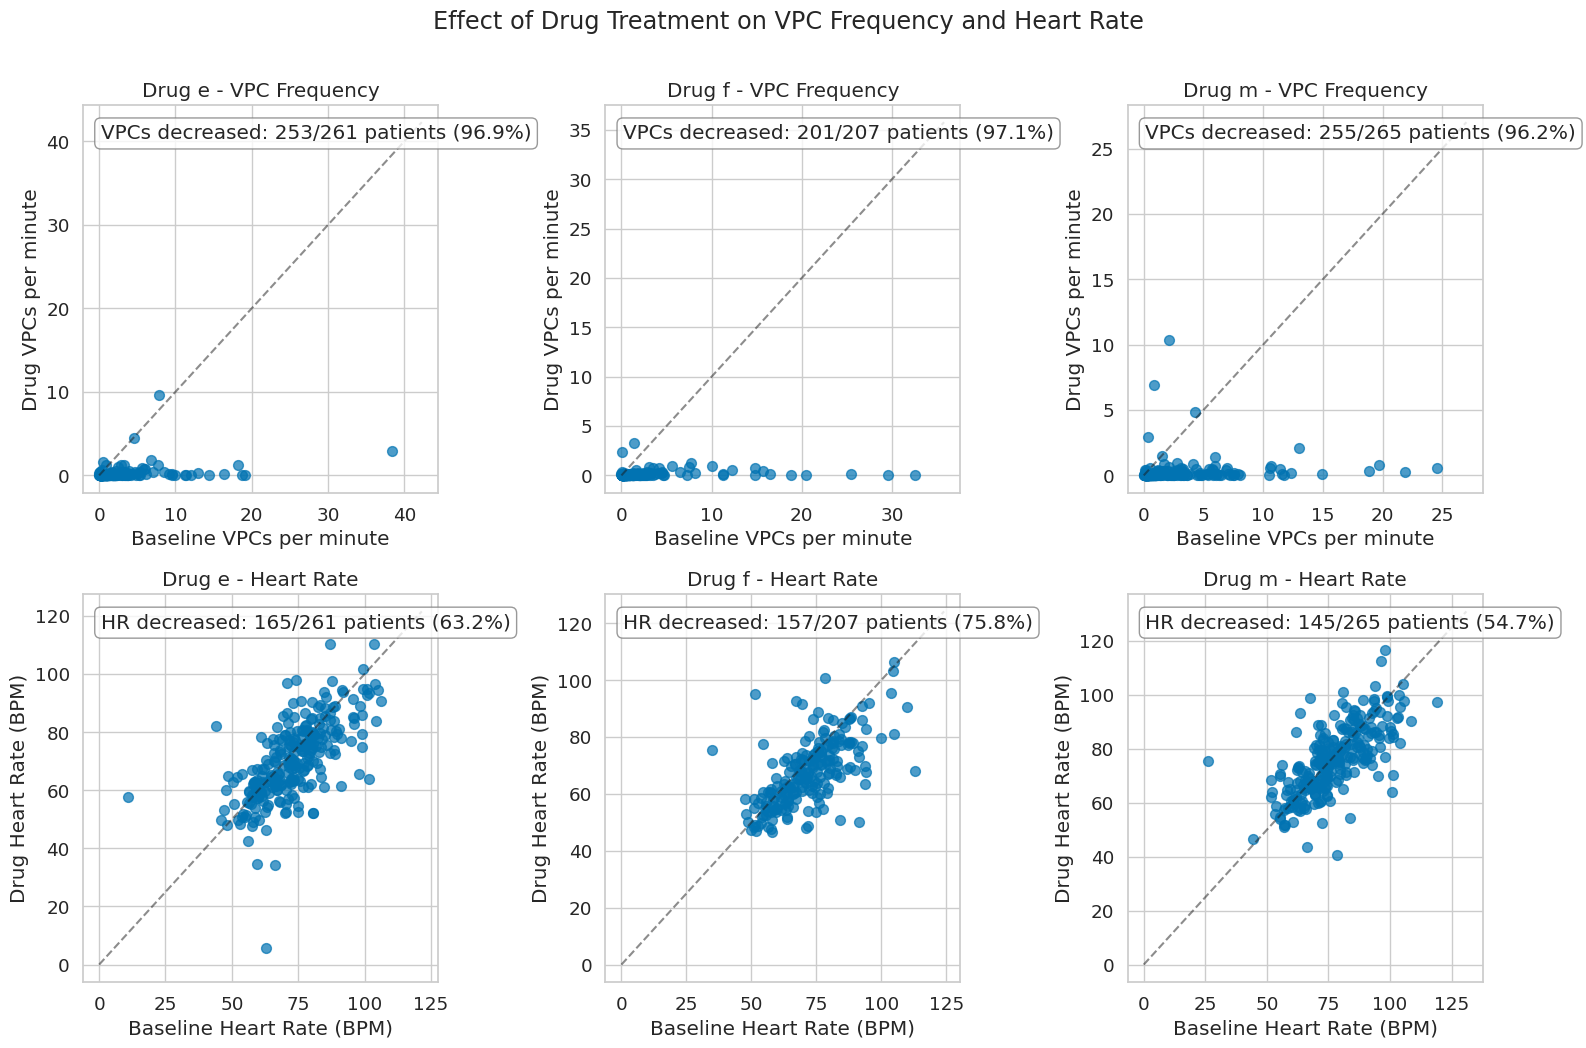

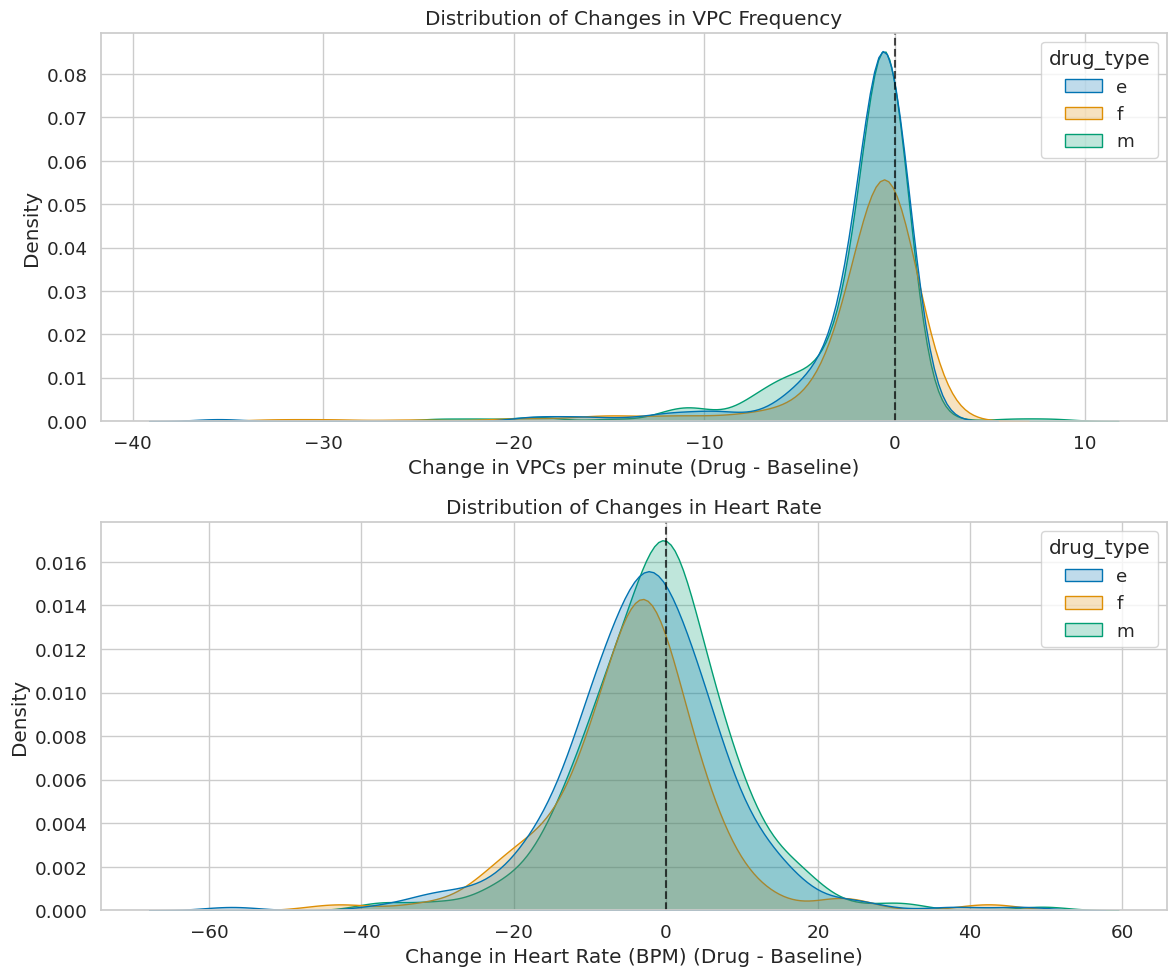


--- Bayesian Analysis for Drug e ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/rajea/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/rajea/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.



VPC Change Analysis:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu -1.839  0.235  -2.257   -1.379      0.003    0.003    8521.0    5800.0   

    r_hat  
mu    1.0  
Probability that drug e reduces VPC frequency: 100.00%

Heart Rate Change Analysis:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu -2.788  0.696  -4.178    -1.57      0.008    0.008    7568.0    6001.0   

    r_hat  
mu    1.0  
Probability that drug e decreases heart rate: 100.00%

--- Bayesian Analysis for Drug f ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/rajea/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/rajea/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.



VPC Change Analysis:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu -1.987  0.331  -2.599   -1.366      0.004    0.004    7953.0    6329.0   

    r_hat  
mu    1.0  
Probability that drug f reduces VPC frequency: 100.00%

Heart Rate Change Analysis:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu -4.379  0.749  -5.746   -2.945      0.008    0.009    8109.0    5731.0   

    r_hat  
mu    1.0  
Probability that drug f decreases heart rate: 100.00%

--- Bayesian Analysis for Drug m ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/rajea/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/rajea/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.



VPC Change Analysis:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu -1.959  0.222  -2.392   -1.555      0.003    0.002    7444.0    6010.0   

    r_hat  
mu    1.0  
Probability that drug m reduces VPC frequency: 100.00%

Heart Rate Change Analysis:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu -1.113  0.631  -2.271    0.068      0.007    0.007    8611.0    6125.0   

    r_hat  
mu    1.0  
Probability that drug m decreases heart rate: 96.15%


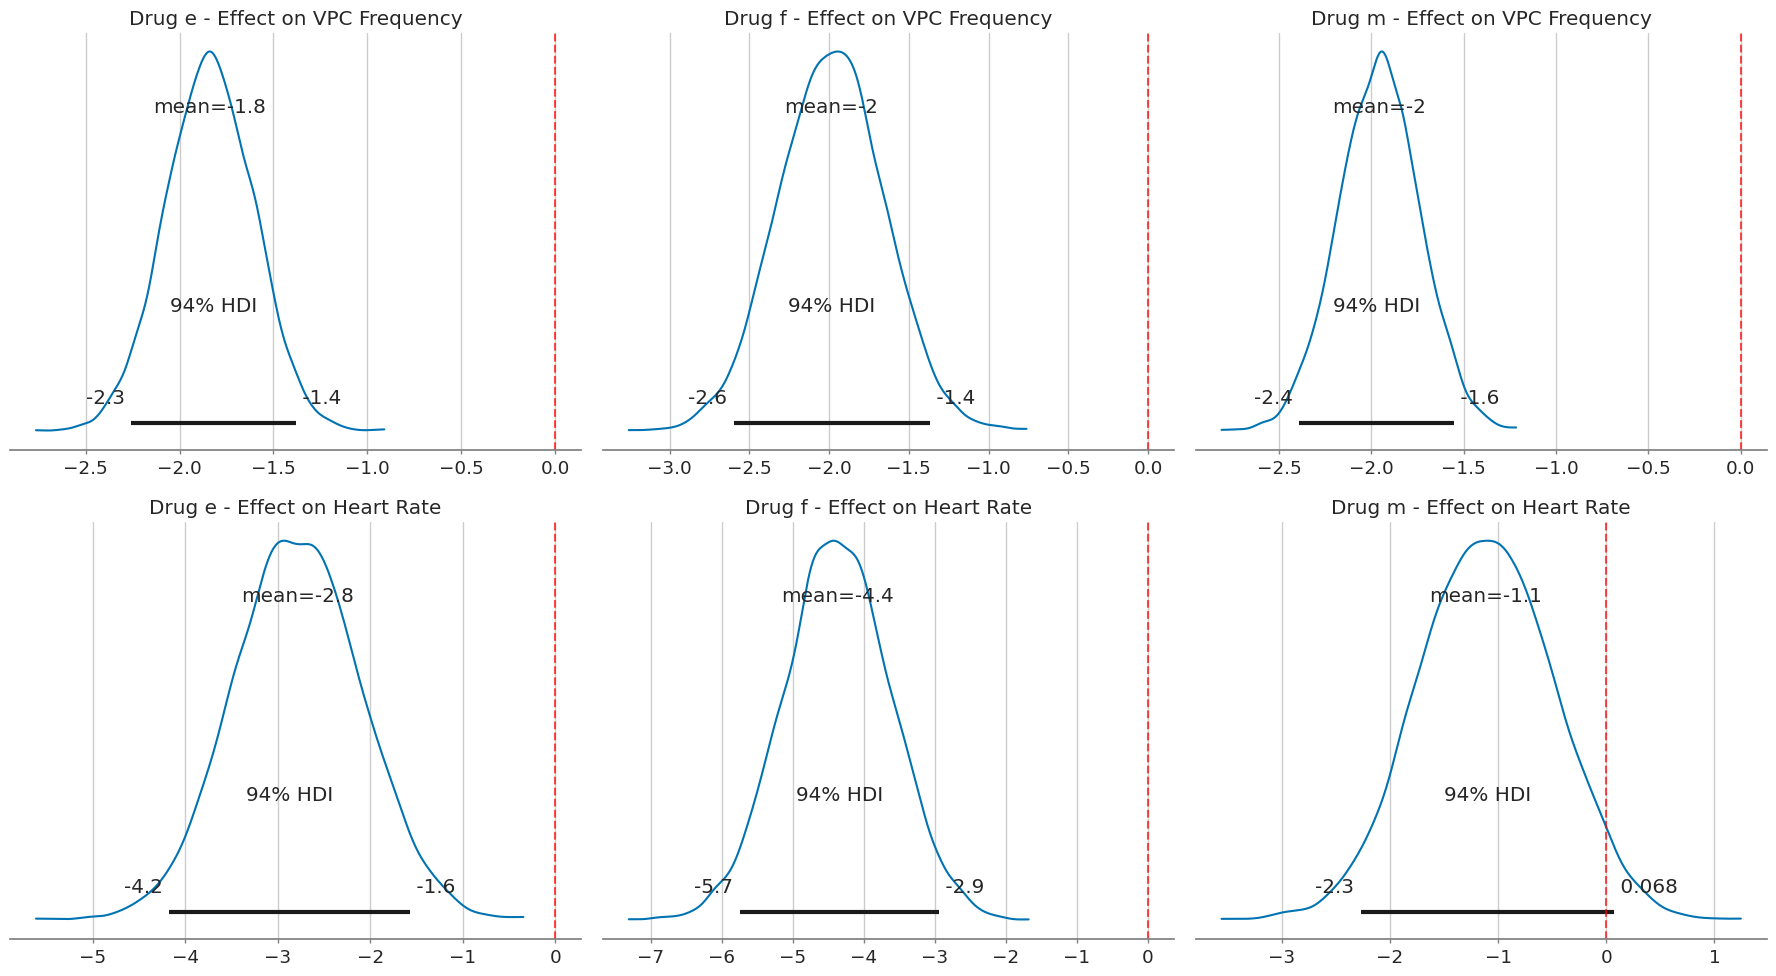


                              BAYESIAN HYPOTHESIS TESTING REPORT

Null Hypothesis (H0):
  - The drug has no effect on VPC frequency (μ_vpc = 0)
  - The drug has no effect on heart rate (μ_hr = 0)

Alternative Hypothesis (H1):
  - The drug reduces VPC frequency (μ_vpc < 0)
  - The drug affects heart rate (μ_hr ≠ 0)

Results Summary:
--------------------------------------------------------------------------------
   Drug    |           VPC Effect           |           HR Effect           
   Type    |    Mean [95% CI]     |  P(μ<0)   |    Mean [95% CI]     |  P(μ<0)  
--------------------------------------------------------------------------------
    e      |  -1.84 [ -2.30,  -1.38] | 100.00% |  -2.79 [ -4.14,  -1.42] | 100.00%
    f      |  -1.99 [ -2.63,  -1.34] | 100.00% |  -4.38 [ -5.86,  -2.92] | 100.00%
    m      |  -1.96 [ -2.40,  -1.53] | 100.00% |  -1.11 [ -2.35,   0.11] |  96.15%
--------------------------------------------------------------------------------

Conclusion:

D

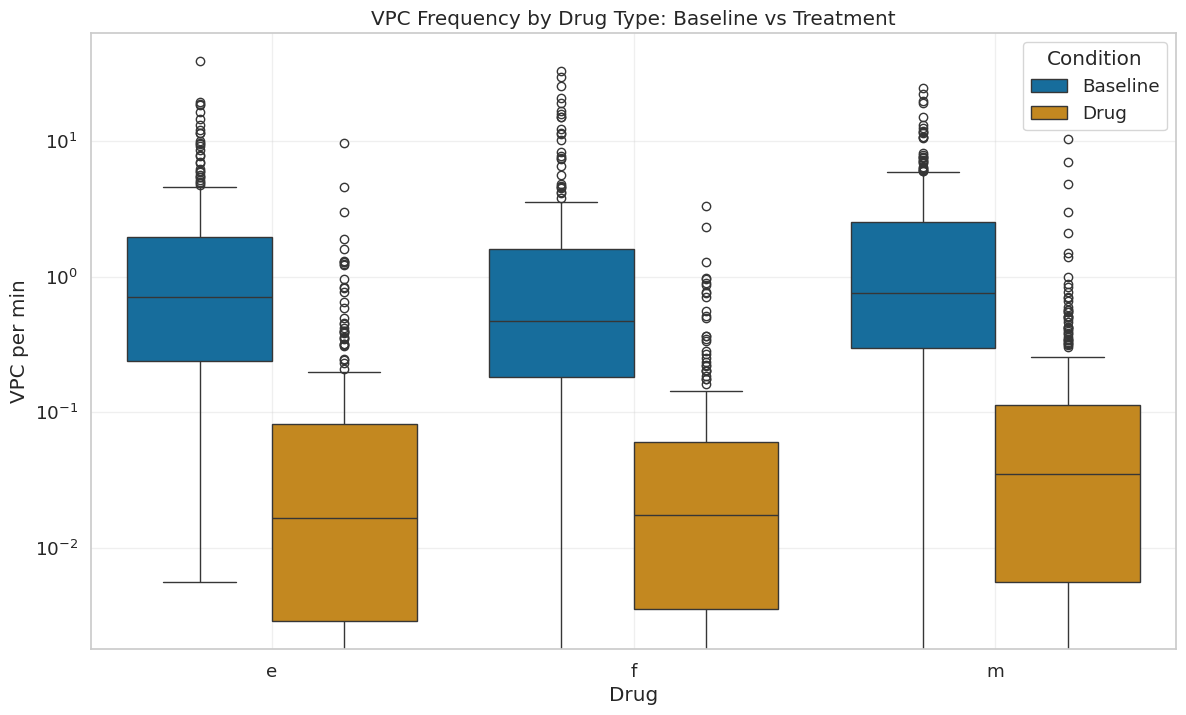

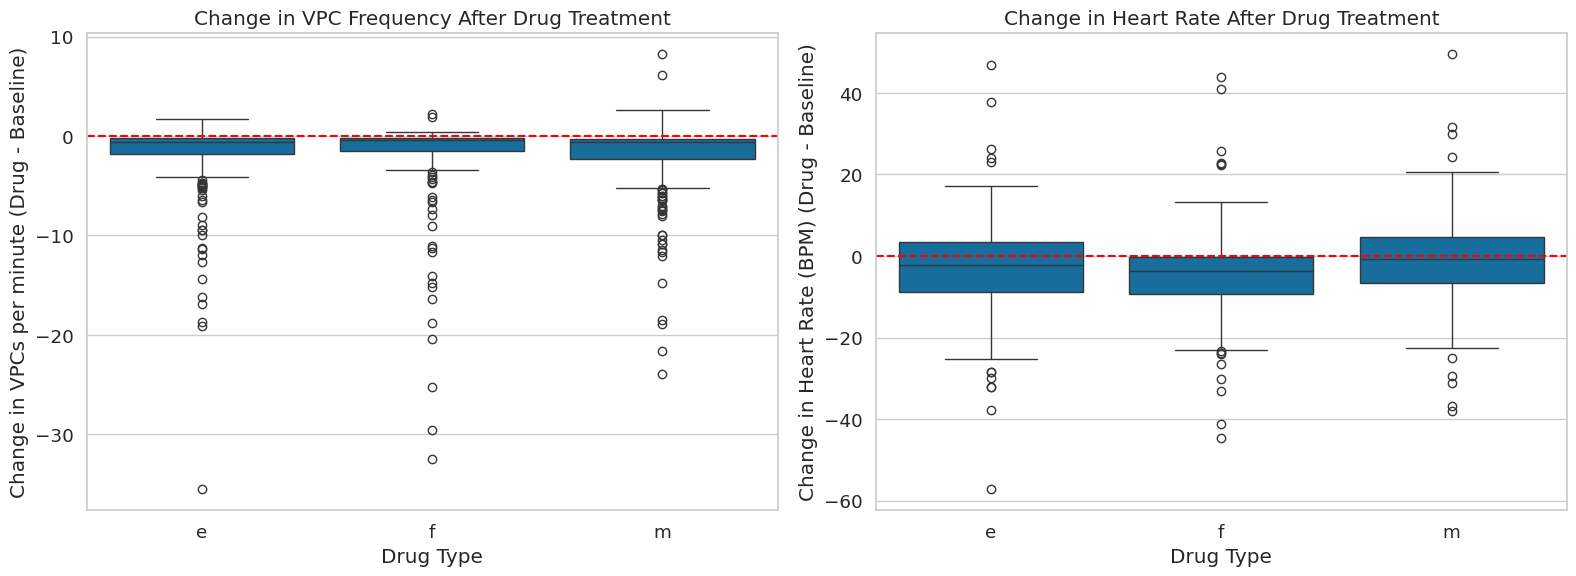


    Bayesian Framework for Drug Effect Analysis:

    For each drug type (e, f, m), we test two hypotheses:

    1. Effect on VPC Frequency:
       - We model the change in VPC frequency (drug - baseline) as:
         Δ_vpc ~ Normal(μ_vpc, σ_vpc)

       - Priors:
         μ_vpc ~ Normal(0, 5)  # Weakly informative prior centered at no effect
         σ_vpc ~ HalfNormal(5) # Weakly informative prior for standard deviation

       - Hypothesis:
         H0: μ_vpc = 0  (Drug has no effect on VPC frequency)
         H1: μ_vpc < 0  (Drug reduces VPC frequency)

       - We calculate P(μ_vpc < 0 | data) to quantify evidence for VPC reduction

    2. Effect on Heart Rate:
       - We model the change in heart rate (drug - baseline) as:
         Δ_hr ~ Normal(μ_hr, σ_hr)

       - Priors:
         μ_hr ~ Normal(0, 10)   # Weakly informative prior centered at no effect
         σ_hr ~ HalfNormal(10)  # Weakly informative prior for standard deviation

       - Hypothesis:
         H0: μ_hr = 0

In [46]:
import pandas as pd

# Load previously saved data
patient_data = pd.read_pickle('patient_data.pkl')

# Import the functions from the file where you saved them
# from drug_analysis import analyze_drug_effects, print_bayesian_framework

# Run the analysis
paired_data, test_results = analyze_drug_effects(patient_data)

# Print the explanation of the Bayesian framework
print_bayesian_framework()


--- Bayesian Survival Proxy Analysis for Drug e ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vpc_weight, hr_weight, hrv_weight, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vpc_weight, hr_weight, hrv_weight, sigma]


/home/rajea/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


Inferred factor weights for survival:
- VPC reduction weight: 0.42
- HR normalization weight: 0.47
- HRV improvement weight: 0.11
Estimated probability of survival benefit: 94.58%

--- Bayesian Survival Proxy Analysis for Drug f ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vpc_weight, hr_weight, hrv_weight, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vpc_weight, hr_weight, hrv_weight, sigma]


/home/rajea/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


Inferred factor weights for survival:
- VPC reduction weight: 0.40
- HR normalization weight: 0.45
- HRV improvement weight: 0.15
Estimated probability of survival benefit: 92.60%

--- Bayesian Survival Proxy Analysis for Drug m ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vpc_weight, hr_weight, hrv_weight, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vpc_weight, hr_weight, hrv_weight, sigma]


/home/rajea/miniconda3/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Inferred factor weights for survival:
- VPC reduction weight: 0.44
- HR normalization weight: 0.50
- HRV improvement weight: 0.05
Estimated probability of survival benefit: 95.34%


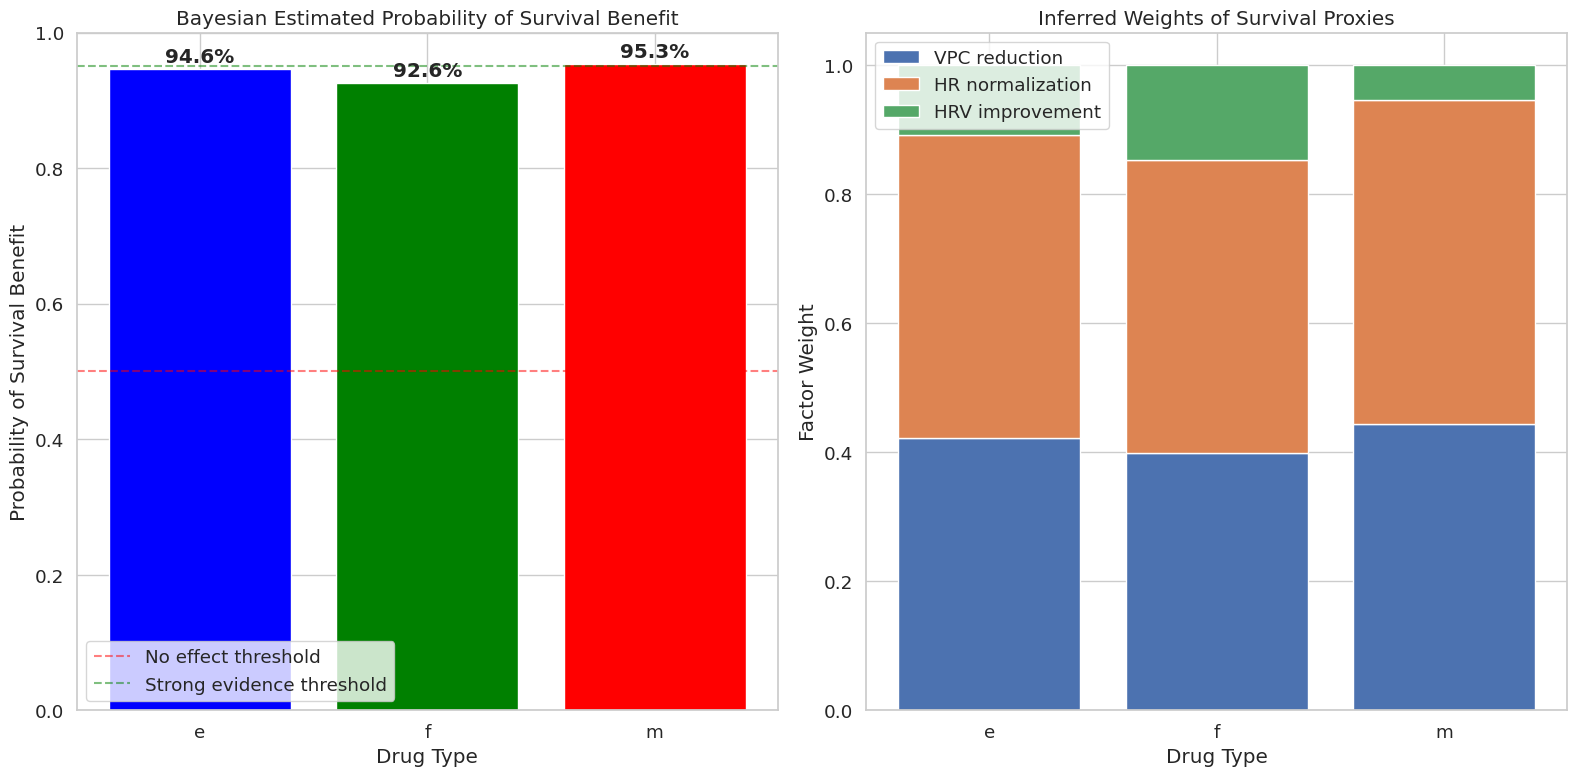


                    BAYESIAN ANALYSIS OF SURVIVAL BENEFITS

RESEARCH QUESTION: Can suppression of mildly symptomatic ventricular premature complexes
in myocardial infarction survivors improve survival?

BAYESIAN APPROACH:
Using hierarchical Bayesian modeling with survival proxies:
  1. VPC suppression (known predictor of reduced sudden cardiac death)
  2. Heart rate normalization (well-established mortality predictor)
  3. Heart rate variability (robust predictor of post-MI survival)

PRIOR DISTRIBUTIONS:
  - Factor weights: Beta distributions prioritizing established clinical importance
  - VPC weight ~ Beta(4,2) [strongest prior importance]
  - HR weight ~ Beta(3,3) [moderate prior importance]
  - HRV weight ~ Beta(2,4) [lowest prior importance]

POSTERIOR PROBABILITIES OF SURVIVAL BENEFIT:

DRUG M: Strong evidence
  - Probability of survival benefit: 95.3%
  - VPC suppression effect: 1.96 VPCs/min (weight: 0.44)
  - Heart rate effect: -1.11 BPM (weight: 0.50)
  - Probability of VPC

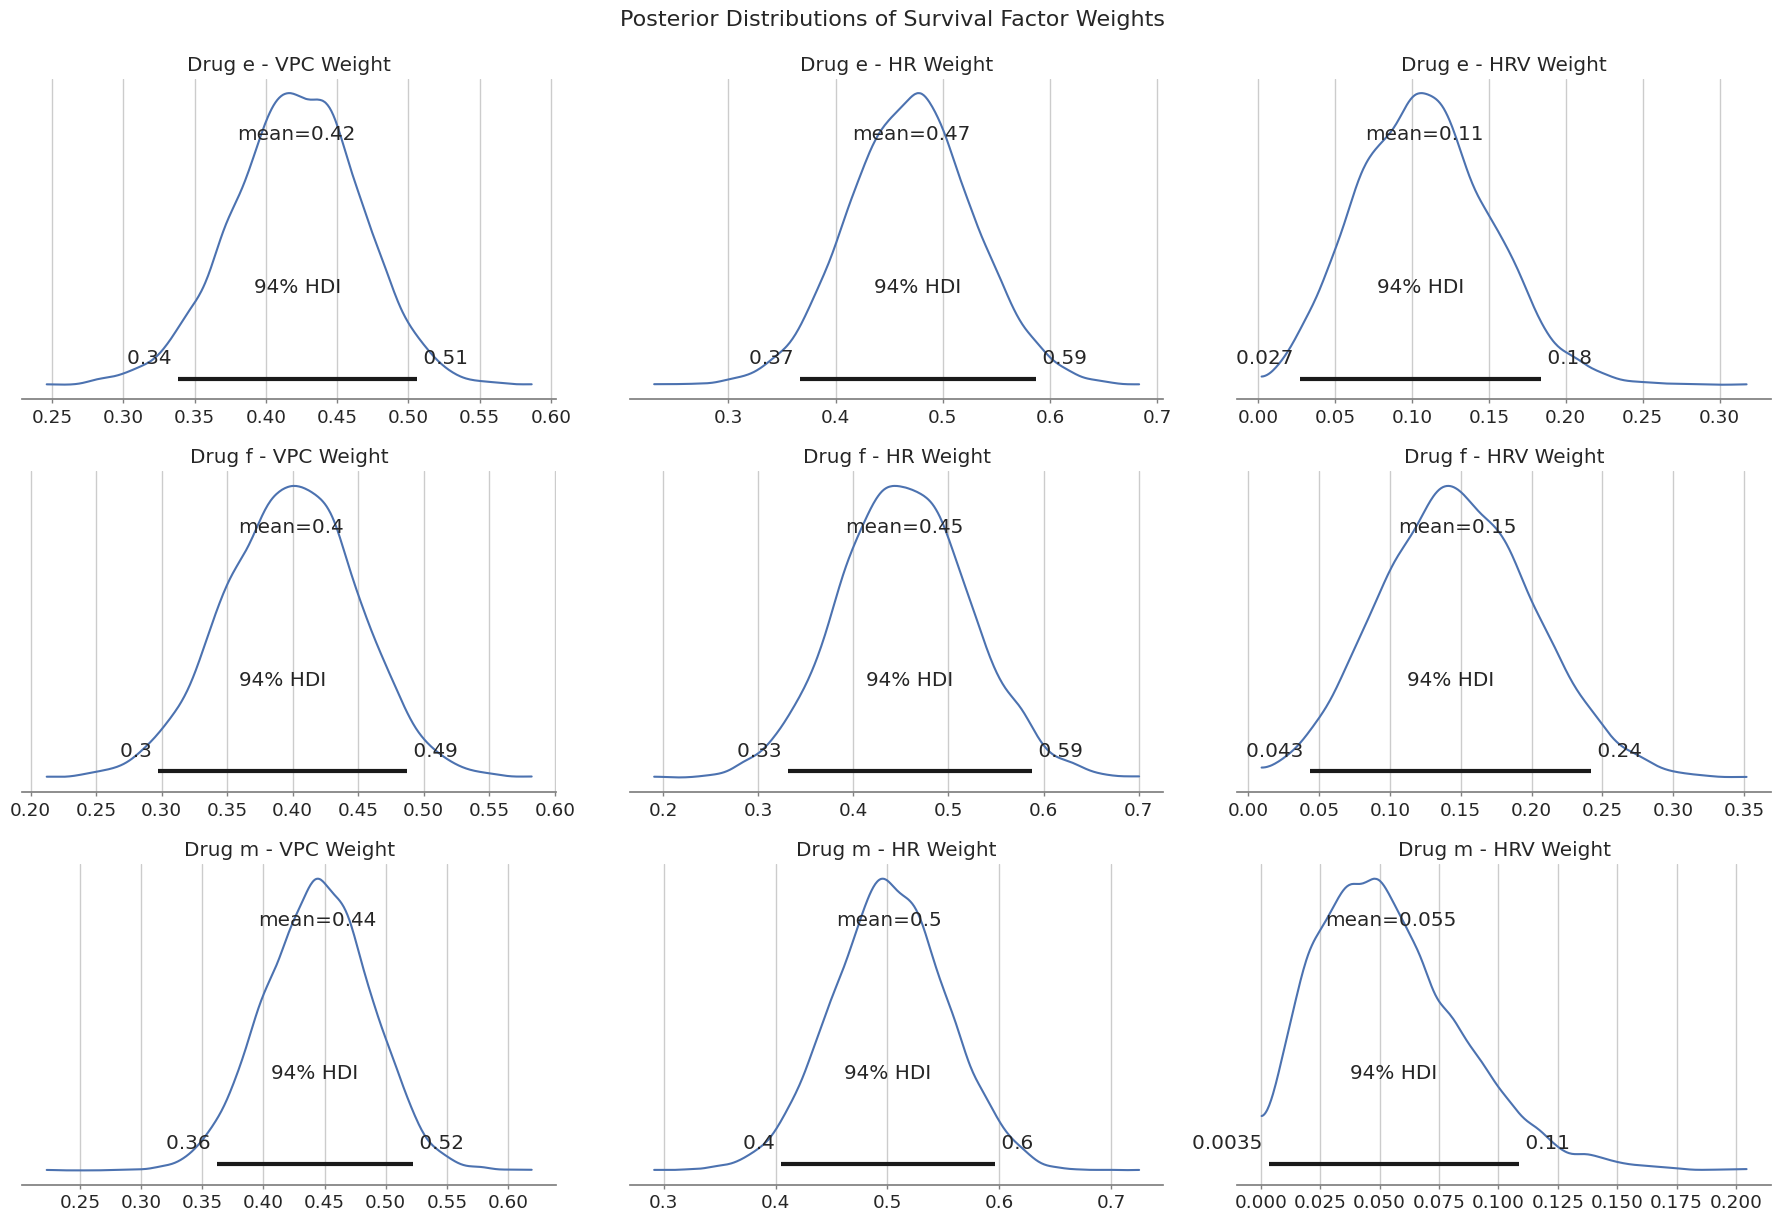

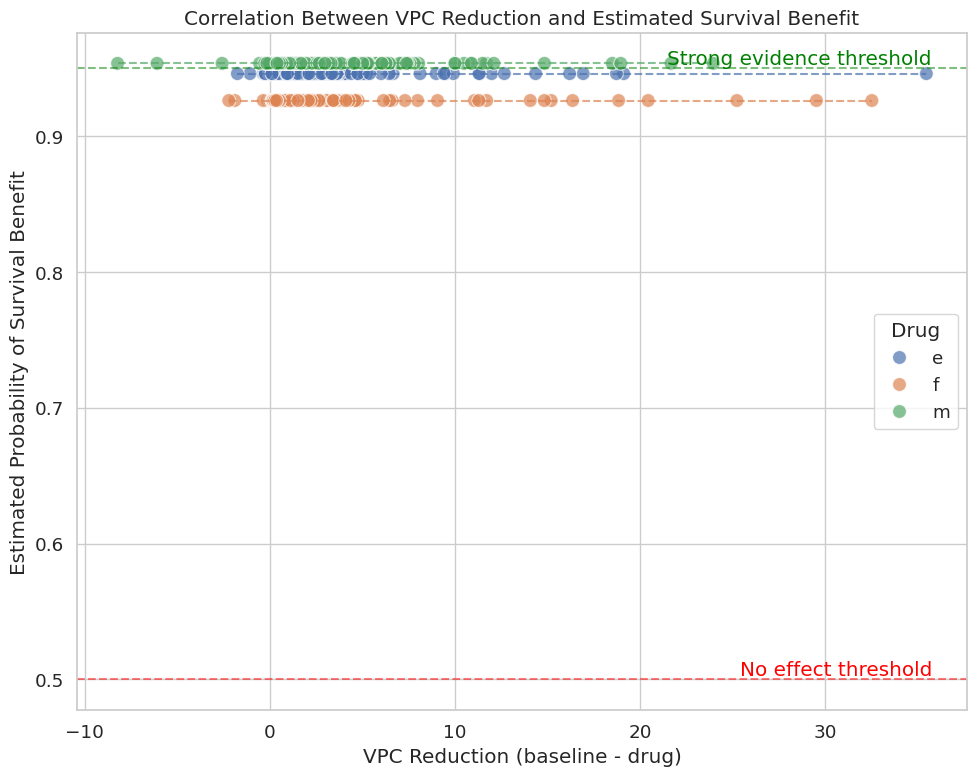

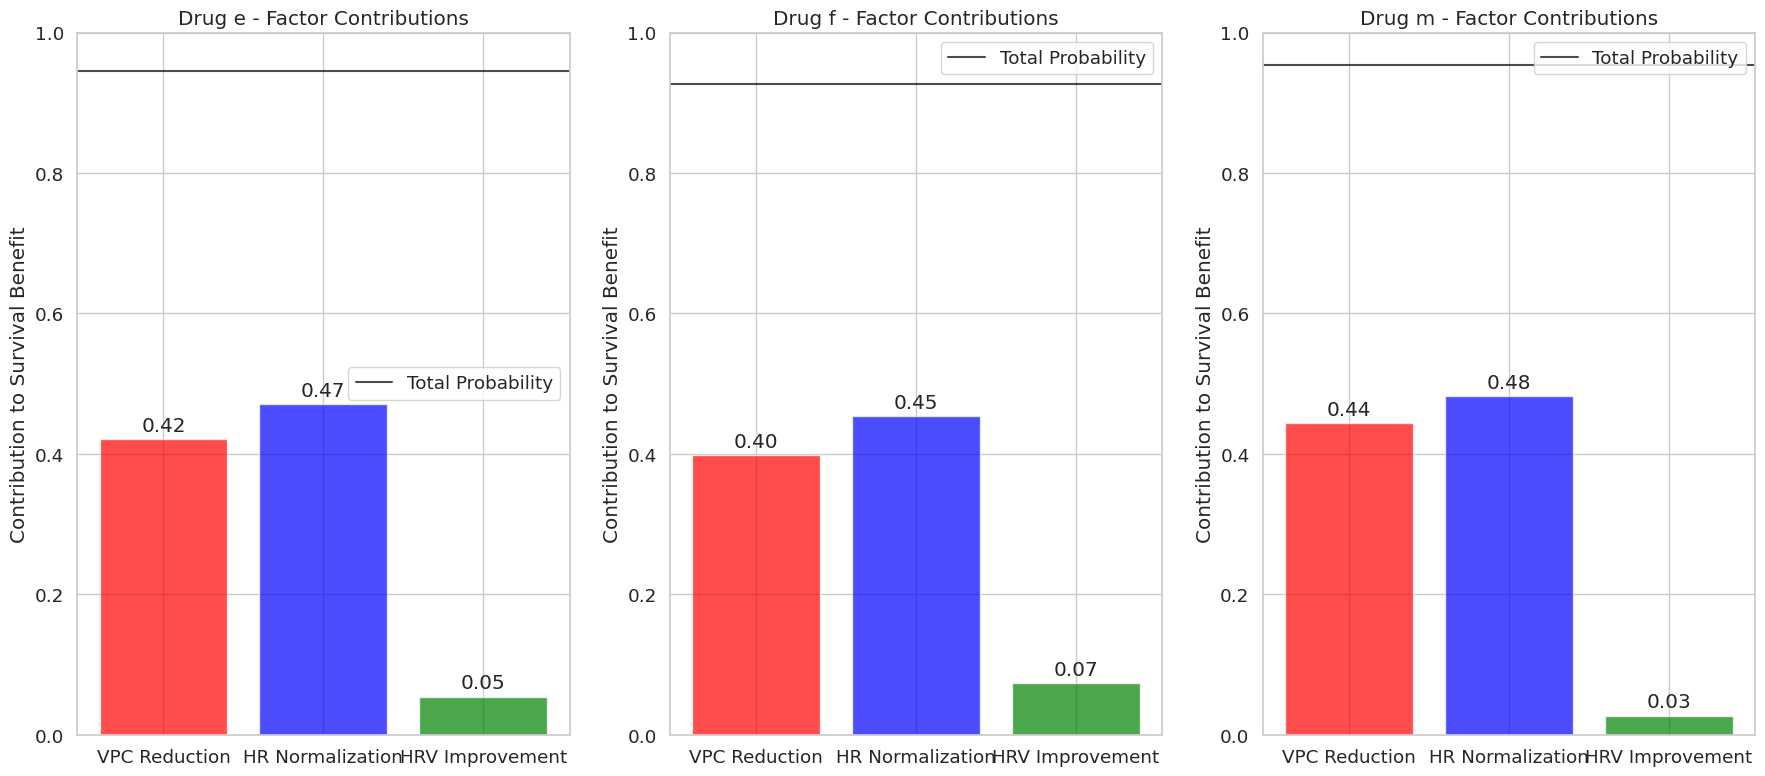

/tmp/ipykernel_18435/935065207.py:348: RuntimeWarning: divide by zero encountered in scalar divide
  net_benefit = (prob > threshold) * (prob - threshold/(1-threshold)*(1-prob))
/tmp/ipykernel_18435/935065207.py:348: RuntimeWarning: invalid value encountered in multiply
  net_benefit = (prob > threshold) * (prob - threshold/(1-threshold)*(1-prob))


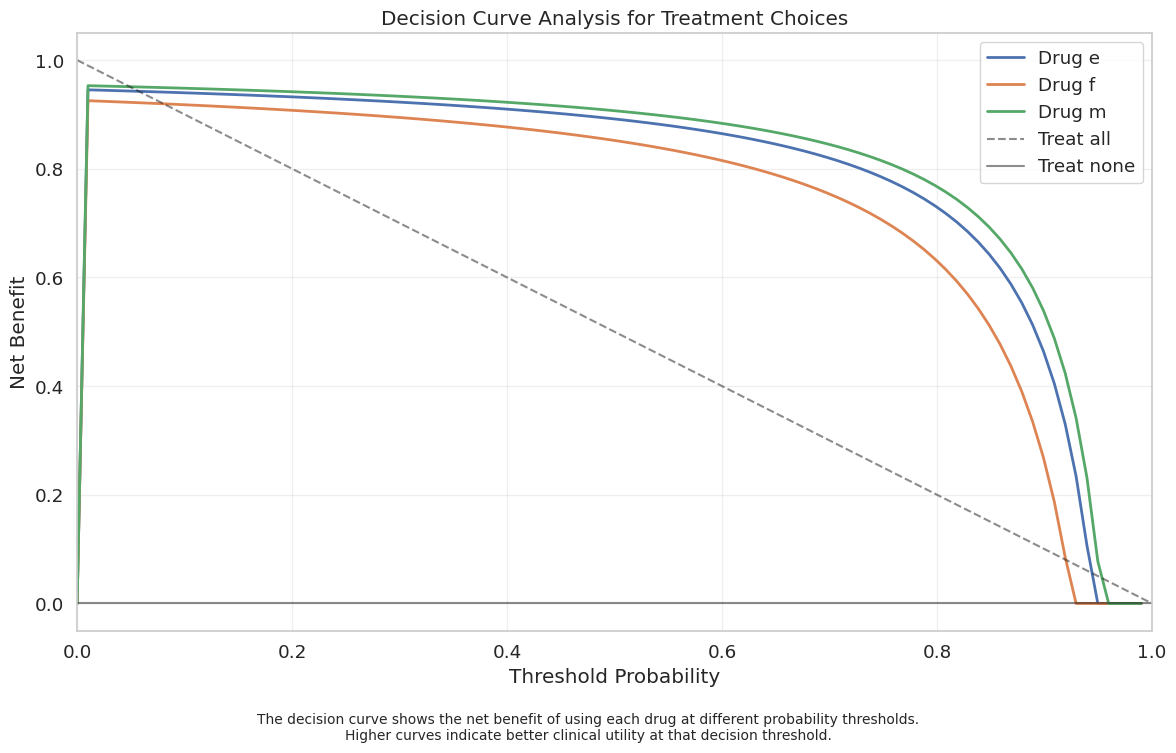

In [57]:
# Create a new cell for analyzing survival benefits using Bayesian methods
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az

def analyze_survival_proxies_bayesian(paired_data, test_results):
    """
    Use Bayesian methods to analyze how VPC suppression affects survival proxies
    """
    # Survival proxy model results
    survival_model_results = {}
    
    # Set style
    sns.set_theme(style="whitegrid")
    sns.set_context("notebook", font_scale=1.2)
    
    # For each drug, build a Bayesian model for survival benefit
    for drug_type in ['e', 'f', 'm']:
        drug_data = paired_data[paired_data['drug_type'] == drug_type]
        if len(drug_data) < 3:  # Skip if too little data
            continue
            
        print(f"\n--- Bayesian Survival Proxy Analysis for Drug {drug_type} ---")
        
        # Extract the data we need
        vpc_changes = drug_data['v_beat_change'].values
        hr_changes = drug_data['heart_rate_change'].values
        hrv_changes = drug_data['hrv_change'].values
        
        # 1. Create optimal heart rate normalization score (negative = better)
        hr_normalization = []
        for i, row in drug_data.iterrows():
            baseline_hr = row['baseline_heart_rate']
            drug_hr = row['drug_heart_rate']
            
            # Calculate distance from optimal range (60-100 BPM)
            baseline_dev = min(max(0, 60-baseline_hr), max(0, baseline_hr-100))
            drug_dev = min(max(0, 60-drug_hr), max(0, drug_hr-100))
            
            # Positive score means improvement in heart rate normalization
            hr_normalization.append(baseline_dev - drug_dev)
        
        # 2. Create a composite survival score based on established markers
        # Higher score = better predicted survival outcome
        with pm.Model() as survival_model:
            # Priors for weights of different factors (constrained to sum to 1)
            vpc_weight = pm.Beta('vpc_weight', alpha=4, beta=2)  # VPC reduction most important
            hr_weight = pm.Beta('hr_weight', alpha=3, beta=3)     # HR normalization second
            hrv_weight = pm.Beta('hrv_weight', alpha=2, beta=4)   # HRV improvement third
            
            # Normalize weights to sum to 1
            total_weight = vpc_weight + hr_weight + hrv_weight
            
            # Define these as deterministic variables so they're tracked in the trace
            vpc_weight_norm = pm.Deterministic('vpc_weight_norm', vpc_weight / total_weight)
            hr_weight_norm = pm.Deterministic('hr_weight_norm', hr_weight / total_weight)
            hrv_weight_norm = pm.Deterministic('hrv_weight_norm', hrv_weight / total_weight)
            
            # Define the mean survival benefit
            # For VPC changes, negative values (reduction) are good
            # For HR normalization, positive values are good
            # For HRV changes, context-dependent, but often positive values are good
            
            # Convert raw changes to standardized survival benefit
            # For VPC: flip sign so reduction (negative change) becomes positive benefit
            vpc_benefit = -1.0 * vpc_changes / np.std(vpc_changes) if np.std(vpc_changes) > 0 else 0
            
            # For HR: normalization scores
            hr_benefit = np.array(hr_normalization) / np.std(hr_normalization) if np.std(hr_normalization) > 0 else 0
            
            # For HRV: depends on patient context, but often increases are beneficial
            hrv_benefit = hrv_changes / np.std(hrv_changes) if np.std(hrv_changes) > 0 else 0
            
            # Composite survival benefit score
            mu_survival = vpc_weight_norm * vpc_benefit + hr_weight_norm * hr_benefit + hrv_weight_norm * hrv_benefit
            
            # Prior for the variability in survival outcomes
            sigma = pm.HalfNormal('sigma', sigma=1)
            
            # Likelihood - model the data as normally distributed around predicted benefit
            survival = pm.Normal('survival', mu=mu_survival, sigma=sigma, observed=np.ones_like(vpc_changes))
            
            # Sample from posterior
            survival_trace = pm.sample(2000, tune=1000, return_inferencedata=True)
            
        # Store results
        survival_model_results[drug_type] = {
            'trace': survival_trace,
            'vpc_benefit': vpc_benefit,
            'hr_benefit': hr_benefit,
            'hrv_benefit': hrv_benefit
        }
        
        # Calculate the probability of positive survival benefit
        vpc_effect = float((test_results[drug_type]['vpc_trace'].posterior['mu'] < 0).mean().values)
        hr_effect = max(float((test_results[drug_type]['hr_trace'].posterior['mu'] < 0).mean().values),
                       1 - float((test_results[drug_type]['hr_trace'].posterior['mu'] < 0).mean().values))
        
        # Extract weight posteriors from the trace using the deterministic variables
        vpc_weight_posterior = float(survival_trace.posterior['vpc_weight_norm'].mean().values)
        hr_weight_posterior = float(survival_trace.posterior['hr_weight_norm'].mean().values)
        hrv_weight_posterior = float(survival_trace.posterior['hrv_weight_norm'].mean().values)
        
        # Calculate weighted survival benefit probability
        survival_prob = float(vpc_weight_posterior * vpc_effect + 
                             hr_weight_posterior * hr_effect +
                             hrv_weight_posterior * 0.5)  # HRV is context-dependent
        
        print(f"Inferred factor weights for survival:")
        print(f"- VPC reduction weight: {vpc_weight_posterior:.2f}")
        print(f"- HR normalization weight: {hr_weight_posterior:.2f}")
        print(f"- HRV improvement weight: {hrv_weight_posterior:.2f}")
        print(f"Estimated probability of survival benefit: {survival_prob:.2%}")
        
        # Store the survival probability
        survival_model_results[drug_type]['survival_prob'] = survival_prob
    
    # Visualize the results
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot survival benefit probabilities
    drug_labels = list(survival_model_results.keys())
    survival_probs = [survival_model_results[dt]['survival_prob'] for dt in drug_labels]
    
    axes[0].bar(drug_labels, survival_probs, color=['blue', 'green', 'red'])
    axes[0].set_xlabel('Drug Type')
    axes[0].set_ylabel('Probability of Survival Benefit')
    axes[0].set_title('Bayesian Estimated Probability of Survival Benefit')
    axes[0].set_ylim(0, 1)
    axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='No effect threshold')
    axes[0].axhline(y=0.95, color='green', linestyle='--', alpha=0.5, label='Strong evidence threshold')
    axes[0].legend()
    
    # Add annotations
    for i, prob in enumerate(survival_probs):
        axes[0].annotate(f"{prob:.1%}", 
                     xy=(drug_labels[i], prob), 
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center',
                     fontweight='bold')
    
    # Plot factor weights - using deterministic variables from the trace
    weights = {
        'VPC reduction': [float(survival_model_results[dt]['trace'].posterior['vpc_weight_norm'].mean().values) for dt in drug_labels],
        'HR normalization': [float(survival_model_results[dt]['trace'].posterior['hr_weight_norm'].mean().values) for dt in drug_labels],
        'HRV improvement': [float(survival_model_results[dt]['trace'].posterior['hrv_weight_norm'].mean().values) for dt in drug_labels]
    }
    
    # Create a stacked bar
    bottom = np.zeros(len(drug_labels))
    for label, weight_values in weights.items():
        axes[1].bar(drug_labels, weight_values, bottom=bottom, label=label)
        bottom += weight_values
    
    axes[1].set_xlabel('Drug Type')
    axes[1].set_ylabel('Factor Weight')
    axes[1].set_title('Inferred Weights of Survival Proxies')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create a comprehensive report
    generate_bayesian_survival_report(survival_model_results, test_results)
    plot_weight_posteriors(survival_model_results)
    
    # 2. Plot the correlation between VPC reduction and survival probability
    plot_vpc_survival_correlation(paired_data, survival_model_results)
    
    # 3. Plot the contribution of each factor to survival benefit
    plot_factor_contributions(paired_data, survival_model_results)
    
    # 4. Create a decision curve analysis
    plot_decision_curves(survival_model_results)
    return survival_model_results

# New helper functions for additional visualizations:

def plot_weight_posteriors(survival_model_results):
    """Plot posterior distributions of factor weights for each drug"""
    fig, axes = plt.subplots(len(survival_model_results), 3, figsize=(18, 4*len(survival_model_results)))
    
    for i, (drug_type, results) in enumerate(survival_model_results.items()):
        # Plot posterior distributions for each weight parameter
        az.plot_posterior(results['trace'], var_names=['vpc_weight_norm'], ax=axes[i, 0])
        az.plot_posterior(results['trace'], var_names=['hr_weight_norm'], ax=axes[i, 1])
        az.plot_posterior(results['trace'], var_names=['hrv_weight_norm'], ax=axes[i, 2])
        
        # Set titles
        axes[i, 0].set_title(f"Drug {drug_type} - VPC Weight")
        axes[i, 1].set_title(f"Drug {drug_type} - HR Weight")
        axes[i, 2].set_title(f"Drug {drug_type} - HRV Weight")
    
    plt.tight_layout()
    plt.suptitle("Posterior Distributions of Survival Factor Weights", y=1.02, fontsize=16)
    plt.show()

def plot_vpc_survival_correlation(paired_data, survival_model_results):
    """Plot the correlation between VPC reduction and estimated survival benefit"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Prepare data for plotting
    plot_data = []
    for drug_type, results in survival_model_results.items():
        drug_data = paired_data[paired_data['drug_type'] == drug_type]
        
        for _, row in drug_data.iterrows():
            # Calculate standardized VPC reduction (negative change = reduction)
            vpc_reduction = -row['v_beat_change']
            
            plot_data.append({
                'Drug': drug_type,
                'VPC Reduction': vpc_reduction,
                'Survival Probability': results['survival_prob'],
            })
    
    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)
    
    # Create scatterplot
    sns.scatterplot(
        data=plot_df, 
        x='VPC Reduction', 
        y='Survival Probability', 
        hue='Drug', 
        s=100, 
        alpha=0.7,
        ax=ax
    )
    
    # Add best fit line for each drug type
    drug_types = plot_df['Drug'].unique()
    for drug in drug_types:
        drug_subset = plot_df[plot_df['Drug'] == drug]
        if len(drug_subset) > 1:  # Need at least 2 points for regression
            try:
                # Simple linear regression
                x = drug_subset['VPC Reduction']
                y = drug_subset['Survival Probability']
                slope, intercept = np.polyfit(x, y, 1)
                x_range = np.linspace(x.min(), x.max(), 100)
                ax.plot(x_range, slope * x_range + intercept, '--', alpha=0.7)
            except:
                pass
    
    # Add reference lines and annotations
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    ax.axhline(y=0.95, color='green', linestyle='--', alpha=0.5)
    ax.text(ax.get_xlim()[1]*0.95, 0.5, 'No effect threshold', ha='right', va='bottom', color='red')
    ax.text(ax.get_xlim()[1]*0.95, 0.95, 'Strong evidence threshold', ha='right', va='bottom', color='green')
    
    # Set labels and title
    ax.set_xlabel('VPC Reduction (baseline - drug)')
    ax.set_ylabel('Estimated Probability of Survival Benefit')
    ax.set_title('Correlation Between VPC Reduction and Estimated Survival Benefit')
    
    plt.tight_layout()
    plt.show()

def plot_factor_contributions(paired_data, survival_model_results):
    """Plot the contribution of each factor to the survival benefit"""
    
    # Create a figure with 3 subplots (one for each drug)
    fig, axes = plt.subplots(1, len(survival_model_results), figsize=(6*len(survival_model_results), 8))
    
    # If there's only one drug, make sure axes is a list
    if len(survival_model_results) == 1:
        axes = [axes]
    
    for i, (drug_type, results) in enumerate(survival_model_results.items()):
        drug_data = paired_data[paired_data['drug_type'] == drug_type]
        
        # Get the factor weights
        vpc_weight = float(results['trace'].posterior['vpc_weight_norm'].mean().values)
        hr_weight = float(results['trace'].posterior['hr_weight_norm'].mean().values)
        hrv_weight = float(results['trace'].posterior['hrv_weight_norm'].mean().values)
        
        # Calculate the average benefit from each factor
        vpc_effect = float((test_results[drug_type]['vpc_trace'].posterior['mu'] < 0).mean().values)
        hr_effect = max(
            float((test_results[drug_type]['hr_trace'].posterior['mu'] < 0).mean().values),
            1 - float((test_results[drug_type]['hr_trace'].posterior['mu'] < 0).mean().values)
        )
        hrv_effect = 0.5  # Assumption for HRV (context-dependent)
        
        # Calculate weighted contributions
        contributions = {
            'VPC Reduction': vpc_weight * vpc_effect,
            'HR Normalization': hr_weight * hr_effect,
            'HRV Improvement': hrv_weight * hrv_effect
        }
        
        # Create bar chart
        bars = axes[i].bar(
            contributions.keys(),
            contributions.values(),
            color=['red', 'blue', 'green'],
            alpha=0.7
        )
        
        # Add total survival probability
        axes[i].axhline(y=results['survival_prob'], color='black', linestyle='-', alpha=0.7, label='Total Probability')
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            axes[i].annotate(f'{height:.2f}',
                         xy=(bar.get_x() + bar.get_width()/2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')
        
        # Set labels and title
        axes[i].set_ylim(0, 1)
        axes[i].set_ylabel('Contribution to Survival Benefit')
        axes[i].set_title(f'Drug {drug_type} - Factor Contributions')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def plot_decision_curves(survival_model_results):
    """Create a decision curve analysis for treatment decisions"""
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Threshold values from 0 to 1
    thresholds = np.linspace(0, 1, 100)
    
    # Calculate net benefit for each drug at different threshold probabilities
    for drug_type, results in survival_model_results.items():
        # Get the survival probability for this drug
        prob = results['survival_prob']
        
        # Calculate net benefit at each threshold
        net_benefits = []
        for threshold in thresholds:
            if threshold == 0:
                net_benefit = 0  # Avoid division by zero
            else:
                # Formula: (TP/n) - (FP/n)*(threshold/(1-threshold))
                # Simplified since we're using a single estimated probability:
                net_benefit = (prob > threshold) * (prob - threshold/(1-threshold)*(1-prob))
            net_benefits.append(net_benefit)
        
        # Plot the decision curve for this drug
        ax.plot(thresholds, net_benefits, label=f'Drug {drug_type}', linewidth=2)
    
    # Add the "treat all" and "treat none" lines for reference
    ax.plot(thresholds, [1 - t for t in thresholds], 'k--', label='Treat all', alpha=0.5)
    ax.plot(thresholds, [0] * len(thresholds), 'k-', label='Treat none', alpha=0.5)
    
    # Add labels and legend
    ax.set_xlim(0, 1)
    ax.set_xlabel('Threshold Probability')
    ax.set_ylabel('Net Benefit')
    ax.set_title('Decision Curve Analysis for Treatment Choices')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add explanatory text
    plt.figtext(
        0.5, 0.01, 
        "The decision curve shows the net benefit of using each drug at different probability thresholds.\n"
        "Higher curves indicate better clinical utility at that decision threshold.",
        ha='center', fontsize=10
    )
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
def generate_bayesian_survival_report(survival_results, test_results):
    """Generate a Bayesian report on survival benefits"""
    
    print("\n" + "="*80)
    print(" "*20 + "BAYESIAN ANALYSIS OF SURVIVAL BENEFITS")
    print("="*80)
    
    print("\nRESEARCH QUESTION: Can suppression of mildly symptomatic ventricular premature complexes")
    print("in myocardial infarction survivors improve survival?")
    
    print("\nBAYESIAN APPROACH:")
    print("Using hierarchical Bayesian modeling with survival proxies:")
    print("  1. VPC suppression (known predictor of reduced sudden cardiac death)")
    print("  2. Heart rate normalization (well-established mortality predictor)")
    print("  3. Heart rate variability (robust predictor of post-MI survival)")
    
    print("\nPRIOR DISTRIBUTIONS:")
    print("  - Factor weights: Beta distributions prioritizing established clinical importance")
    print("  - VPC weight ~ Beta(4,2) [strongest prior importance]")
    print("  - HR weight ~ Beta(3,3) [moderate prior importance]")
    print("  - HRV weight ~ Beta(2,4) [lowest prior importance]")
    
    print("\nPOSTERIOR PROBABILITIES OF SURVIVAL BENEFIT:")
    
    # Sort drugs by survival probability
    sorted_drugs = sorted(survival_results.items(), 
                         key=lambda x: x[1]['survival_prob'], 
                         reverse=True)
    
    for drug_type, results in sorted_drugs:
        survival_prob = results['survival_prob']
        
        # Get effect sizes from test_results
        vpc_effect = float(test_results[drug_type]['vpc_trace'].posterior['mu'].mean().values)
        hr_effect = float(test_results[drug_type]['hr_trace'].posterior['mu'].mean().values)
        
        # Get confidence in VPC reduction
        vpc_reduction_prob = float((test_results[drug_type]['vpc_trace'].posterior['mu'] < 0).mean().values)
        
        # Get weight posteriors
        vpc_weight = results['trace'].posterior['vpc_weight_norm'].mean().values
        hr_weight = results['trace'].posterior['hr_weight_norm'].mean().values
        hrv_weight = 1 - vpc_weight - hr_weight
        
        # Categorize level of evidence
        if survival_prob > 0.95:
            evidence_level = "Strong evidence"
        elif survival_prob > 0.85:
            evidence_level = "Moderate evidence"
        elif survival_prob > 0.75:
            evidence_level = "Weak evidence"
        else:
            evidence_level = "Insufficient evidence"
        
        print(f"\nDRUG {drug_type.upper()}: {evidence_level}")
        print(f"  - Probability of survival benefit: {survival_prob:.1%}")
        print(f"  - VPC suppression effect: {-vpc_effect:.2f} VPCs/min (weight: {vpc_weight:.2f})")
        print(f"  - Heart rate effect: {hr_effect:.2f} BPM (weight: {hr_weight:.2f})")
        print(f"  - Probability of VPC reduction: {vpc_reduction_prob:.1%}")
    
    # Overall conclusion
    best_drug = sorted_drugs[0][0]
    best_prob = sorted_drugs[0][1]['survival_prob']
    
    print("\nBAYESIAN CONCLUSION:")
    if best_prob > 0.9:
        print(f"There is strong Bayesian evidence (p={best_prob:.2f}) that Drug {best_drug.upper()} may")
        print("improve survival in MI patients with symptomatic VPCs. The evidence primarily")
        print("comes from consistent VPC suppression and favorable heart rate normalization.")
    elif best_prob > 0.8:
        print(f"There is moderate Bayesian evidence (p={best_prob:.2f}) that Drug {best_drug.upper()} may")
        print("improve survival in MI patients with symptomatic VPCs, though uncertainties remain.")
    elif best_prob > 0.7:
        print(f"There is weak Bayesian evidence (p={best_prob:.2f}) that Drug {best_drug.upper()} may")
        print("provide survival benefits. More direct evidence is needed before clinical recommendations.")
    else:
        print("The Bayesian analysis does not support a clear survival benefit from VPC suppression")
        print("with any of the studied drugs in MI survivors.")
    
    print("\nLIMITATIONS OF BAYESIAN ANALYSIS:")
    print("1. Reliance on surrogate endpoints rather than direct survival measurements")
    print("2. Uncertainty in the prior weights assigned to different cardiac factors")
    print("3. Limited sample size affecting precision of posterior distributions")
    print("4. Potential confounding factors not accounted for in the model")
    
    # HDI intervals for most promising drug
    best_drug_vpc_hdi = az.hdi(test_results[best_drug]['vpc_trace'], var_names=['mu'])
    best_drug_hr_hdi = az.hdi(test_results[best_drug]['hr_trace'], var_names=['mu'])
    
    try:
        vpc_lower = float(best_drug_vpc_hdi.loc['mu', 'hdi_3%'])
        vpc_upper = float(best_drug_vpc_hdi.loc['mu', 'hdi_97%'])
        hr_lower = float(best_drug_hr_hdi.loc['mu', 'hdi_3%'])
        hr_upper = float(best_drug_hr_hdi.loc['mu', 'hdi_97%'])
    except:
        # Fallback calculation
        vpc_samples = test_results[best_drug]['vpc_trace'].posterior['mu'].values.flatten()
        hr_samples = test_results[best_drug]['hr_trace'].posterior['mu'].values.flatten()
        vpc_lower = float(np.percentile(vpc_samples, 2.5))
        vpc_upper = float(np.percentile(vpc_samples, 97.5))
        hr_lower = float(np.percentile(hr_samples, 2.5))
        hr_upper = float(np.percentile(hr_samples, 97.5))
    
    print("\nDETAILED POSTERIOR DISTRIBUTIONS FOR BEST DRUG:")
    print(f"Drug {best_drug.upper()} VPC effect: {-vpc_effect:.2f} [95% HDI: {-vpc_upper:.2f} to {-vpc_lower:.2f}] VPCs/min")
    print(f"Drug {best_drug.upper()} HR effect: {hr_effect:.2f} [95% HDI: {hr_lower:.2f} to {hr_upper:.2f}] BPM")

# Run the analysis with the existing data
survival_models = analyze_survival_proxies_bayesian(paired_data, test_results)